In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

In [2]:
def describe_df(df: pd.DataFrame) -> pd.DataFrame:
    desc = pd.DataFrame({
        'n_unique': df.nunique(),
        'null_share': round(df.isnull().sum() / len(df), 2)
    })
    return desc.reset_index().rename(columns={'index': 'column'})

## D003 dataset ##

In [3]:
d003 = pd.read_csv(r"C:\Users\g1kss\OneDrive\Рабочий стол\stat_datathon_project\D003\synthetic_D003.csv", low_memory=False)

In [6]:
print(d003.info())
print(d003.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19899311 entries, 0 to 19899310
Data columns (total 22 columns):
 #   Column     Dtype  
---  ------     -----  
 0   TE         int64  
 1   K          int64  
 2   KVART      int64  
 3   PARC       int64  
 4   RAZD       float64
 5   DATE_Z     object 
 6   KOL_PR     object 
 7   KOD_PRN    object 
 8   KOD_TU     float64
 9   CUPL_POTR  float64
 10  EDIZM      float64
 11  UPLACH     float64
 12  STOIM      float64
 13  CELPOK     float64
 14  MESTPOK    float64
 15  PRIMECH    object 
 16  STOIM4     float64
 17  CHARDAY    float64
 18  ZT         object 
 19  NOMER      int64  
 20  god        int64  
 21  KOD_INT    float64
dtypes: float64(11), int64(6), object(5)
memory usage: 3.3+ GB
None
(19899311, 22)


In [7]:
column_description = {
    "TE": "Код территории",
    "K": "Код местожительства",
    "NOMER": "Код домохозяйства",
    "KOL_PR": "Количество присутствующих лиц",
    "DATE_Z": "Дата заполнения дневника",
    "KOD_PRN": "Код причин незаполнения",
    "KVART": "Номер квартала",
    "PARC": "Номер части",
    "RAZD": "Номер раздела",
    "KOD_TU": "Код товара",
    "CUPL_POTR": "Куплено-потреблено",
    "EDIZM": "Код единицы измерения",
    "UPLACH": "Уплачено",
    "STOIM": "Стоимость",
    "STOIM4": "Пересчитанная стоимость продуктов питания, полученных из ЛПХ и в подарок (для 3 раздела)",
    "CELPOK": "Цель покупки для разд.2 и 5 — Получение для разд.3 и 4",
    "CHARDAY": "Характеристика дня",
    "PRIMECH": "Примечание (на сколько месяцев хватит купленного в разделе 2)",
    "MESTPOK": "Место покупки",
    "ZT": "Время, затраченное на заполнение анкеты",
    "god": "Год обследования",
    "KOD_INT": "Код интервьюера",
}

In [8]:
cols_to_drop = ['KOD_PRN', 'PRIMECH', 'CHARDAY', 'ZT', 'KOD_INT']
# KOD_PRN = 
d003 = d003.drop(columns=cols_to_drop)

In [9]:
d003_desc = describe_df(d003)

In [11]:
descriptions_d003 = pd.DataFrame.from_dict(column_description, orient='index', columns=['description']).reset_index().rename(columns={'index': 'column'})
d003_desc = d003_desc.merge(descriptions_d003, on='column')

In [12]:
d003.head()

,TE,K,KVART,PARC,RAZD,DATE_Z,KOL_PR,KOD_TU,CUPL_POTR,EDIZM,UPLACH,STOIM,CELPOK,MESTPOK,STOIM4,NOMER,god
0,39,1,4,2,2.0,2020-10-13,6.0,1171001.0,1.630,166.0,518.0,1199.0,1.0,1.0,NaN,35814,2020
1,15,1,3,1,4.0,2020-09-26,3.0,1171002.0,0.003,166.0,1.0,194.0,NaN,2.0,0.0,53102,2020
2,35,1,2,1,2.0,2020-08-22,2.0,1199003.0,0.061,166.0,0.0,281.0,1.0,NaN,0.0,8717,2020
3,19,1,2,1,1.0,2020-09-05,4.0,1172001.0,0.367,166.0,348.0,967.0,NaN,NaN,0.0,35128,2020
4,59,1,2,1,2.0,2020-05-26,2.0,1141101.0,0.175,112.0,304.0,865.0,1.0,1.0,0.0,934,2020


In [13]:
human_readable = {
    "TE": "territory_code",
    "K": "residence_code",
    "NOMER": "household_code",
    "KOL_PR": "number_of_people", 
    "DATE_Z": "date_of_completion",
    "KOD_PRN": "reasons_for_unfilled_code",
    "KVART": "kvartal_number",
    "PARC": "chast_number",
    "RAZD": "razdel_number",
    "KOD_TU": "product_code",
    "CUPL_POTR": "bought_sold",
    "EDIZM": "unit_of_measure_code",
    "UPLACH": "uplacheno",
    "STOIM": "price",
    "STOIM4": "lph_gift_recalc_price", # "Пересчитанная стоимость продуктов питания, полученных из ЛПХ и в подарок (для 3 раздела)",
    "CELPOK": "purchase_purpose", # "Цель покупки для разд.2 и 5 — Получение для разд.3 и 4",
    "CHARDAY": "day_character",
    "PRIMECH": "primechanie", # "Примечание (на сколько месяцев хватит купленного в разделе 2)",
    "MESTPOK": "place_of_purchase", # Место покупки
    "ZT": "time_for_fill",    # "Время, затраченное на заполнение анкеты",
    "god": "year", 
    "KOD_INT": "interviewer_code" 
}

In [14]:
d003 = d003.rename(columns=human_readable)

In [15]:
d003['number_of_people'] = pd.to_numeric(d003['number_of_people'], errors='coerce')
d003.date_of_completion = pd.to_datetime(d003.date_of_completion)

In [16]:
spravka = pd.read_excel(r"C:\Users\g1kss\OneDrive\Рабочий стол\Copy of справочник_товаров_D003.xls")

In [17]:
spravka_cols_rename = {
    'Item_ID': 'item_id',
    'Код': 'product_code',
    'Наименование': 'name_ru',
    'Наименование на английском': 'name_eng',
    'Полное наименование': 'full_name',
    'ID классификации': 'classification_id',
    'Наименование классификации': 'classification_name',
    'Аббревиатура': 'abbrev',
    'Разработчик': 'responsible'
}
spravka.rename(columns=spravka_cols_rename, inplace=True)
spravka.drop(columns=['classification_id', 'classification_name', 'abbrev', 'responsible'], inplace=True)

In [18]:
spravka["full_name"] = spravka["full_name"].str.replace(r"^Всего/", "", regex=True)

In [19]:
spravka["product_category"] = spravka["full_name"].str.split("/").str[0]
spravka["product_subcategory"] = spravka["full_name"].str.split("/").str[1]

In [20]:
spravka["product_category"] = spravka["product_category"].replace(
    "Алкогольные напитки, табачные изделия",
    "Алкогольные напитки и табачные изделия"
)

In [21]:
prodcod = list(d003.product_code.unique())
spravka_codes = list(spravka.product_code.unique())

In [22]:
i = 0
matching_prodcode = []
notmatching_prodcode = []
for cod in prodcod:
    if cod in spravka_codes:
        matching_prodcode.append(cod)
    else:
        notmatching_prodcode.append(cod)

In [23]:
d003_filt = d003[d003['product_code'].isin(matching_prodcode)]

In [24]:
d003_merged = pd.merge(
    d003_filt,
    spravka[['name_ru', 'product_category', 'product_subcategory', 'product_code']],
    on='product_code',
    how='left'
)

In [23]:
household_grouped_df = (
    d003_merged
    .groupby(['household_code', 'year'], as_index=False) # 'product_category'
    .agg(
        total_price=('price', 'sum'),
        average_price=('price', 'mean'),
        median_price=('price', 'median'),
        total_recalc_price=('lph_gift_recalc_price', 'sum'),
        average_recalc_price=('lph_gift_recalc_price', 'mean'),
        median_recalc_price=('lph_gift_recalc_price', 'median'),
        total_uplacheno=('uplacheno', 'sum'),
        average_uplacheno=('uplacheno', 'mean'),
        median_uplacheno=('uplacheno', 'median'),
        total_bought_sold=('bought_sold', 'sum'),
        num_records=('product_code', 'count'),
        average_num_of_people=('number_of_people', 'mean'),
    )
)

In [24]:
d11_full = pd.read_csv('data11_unique.csv')

In [25]:
household_grouped_income_df = (
    d11_full
    .groupby(['household_code', 'year'], as_index=False) # 'product_category'
    .agg(
        total_income=('total_income', 'sum'),
        average_income=('total_income', 'mean'),
        median_income=('total_income', 'median'),
        most_frequent_person=('person', lambda x: x.mode()[0] if not x.mode().empty else None),  # Mode for the person
        most_frequent_residence=('K', lambda x: x.mode()[0] if not x.mode().empty else None),  
    )
)

In [26]:
hh20 = household_grouped_df[household_grouped_df['year']==2020]
hh21 = household_grouped_df[household_grouped_df['year']==2021]
hh22 = household_grouped_df[household_grouped_df['year']==2022]
hh23 = household_grouped_df[household_grouped_df['year']==2023]
hh24 = household_grouped_df[household_grouped_df['year']==2024]

In [27]:
df20 = d003_merged[d003_merged['year']==2020]
df21 = d003_merged[d003_merged['year']==2021]
df22 = d003_merged[d003_merged['year']==2022]
df23 = d003_merged[d003_merged['year']==2023]
df24 = d003_merged[d003_merged['year']==2024]

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

def cluster_and_plot_all_years(dfs_by_year, features):
    """
    Runs KMeans clustering with CV silhouette per year,
    returns cluster DataFrames, summaries, and best scores,
    and plots PCA 2D visualizations for each year.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    results = []  # summary per year
    all_clustered_dfs = {}
    all_aggregated = {}

    for i, (year, data) in enumerate(dfs_by_year.items()):
        # ===== 1. Prepare Data =====
        df = data.dropna(subset=features).copy()
        X = df[features].to_numpy()

        k_values = range(2, 7)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        sil_results = []

        # ===== 2. Cross-validated silhouette per k =====
        for k in k_values:
            fold_scores = []
            for train_idx, test_idx in kf.split(X):
                X_train, X_test = X[train_idx], X[test_idx]

                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X_train)
                X_test_s = scaler.transform(X_test)

                km = KMeans(n_clusters=k, n_init=10, random_state=42)
                km.fit(X_train_s)
                labels_test = km.predict(X_test_s)

                if len(np.unique(labels_test)) > 1:
                    fold_scores.append(silhouette_score(X_test_s, labels_test))

            sil_results.append((k, np.mean(fold_scores)))

        sil_df = pd.DataFrame(sil_results, columns=["k", "sil_mean"])
        best_row = sil_df.loc[sil_df["sil_mean"].idxmax()]
        best_k = int(best_row["k"])
        best_sil = float(best_row["sil_mean"])

        # ===== 3. Fit final model =====
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        km_final = KMeans(n_clusters=best_k, n_init=10, random_state=42)
        km_final.fit(X_scaled)
        labels = km_final.labels_
        df["cluster"] = labels

        # ===== 4. Create aggregated summary =====
        cluster_summary = (
            df.groupby("cluster")[features + ["average_price", "territory_code", "average_recalc_price", "average_num_of_people", "most_frequent_person", "most_frequent_residence"]]
            .mean()
            .round(2)
        )

        # Add cluster counts to summary
        cluster_counts = df["cluster"].value_counts().sort_index()
        cluster_summary["count"] = cluster_summary.index.map(cluster_counts)

        # ===== 5. PCA visualization =====
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        plot_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
        plot_df["cluster"] = labels

        ax = axes[i]
        sns.scatterplot(
            data=plot_df,
            x="PC1", y="PC2",
            hue="cluster", palette="Set2",
            s=45, alpha=0.8, ax=ax
        )
        ax.set_title(f"{year} (k={best_k}, silhouette={best_sil:.3f})", fontsize=12, fontweight="bold")
        ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
        ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend_.remove()

        # ===== 6. Store results =====
        results.append({
            "year": year,
            "best_k": best_k,
            "best_silhouette": best_sil,
            "cluster_counts": cluster_counts.to_dict()
        })
        all_clustered_dfs[year] = df
        all_aggregated[year] = cluster_summary

    # remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Household PCA Clusters by Year (2020–2024)", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # ===== 7. Return everything =====
    results_df = pd.DataFrame(results)[["year", "best_k", "best_silhouette", "cluster_counts"]]
    return results_df, all_clustered_dfs, all_aggregated

In [29]:
hh20_inc = household_grouped_income_df[household_grouped_income_df['year']==2020]
hh21_inc = household_grouped_income_df[household_grouped_income_df['year']==2021]
hh22_inc = household_grouped_income_df[household_grouped_income_df['year']==2022]
hh23_inc = household_grouped_income_df[household_grouped_income_df['year']==2023]
hh24_inc = household_grouped_income_df[household_grouped_income_df['year']==2024]

In [30]:
hh20_merged = hh20_inc.merge(hh20.drop(columns='year'), on='household_code', how='inner')
hh21_merged = hh21_inc.merge(hh21.drop(columns='year'), on='household_code', how='inner')
hh22_merged = hh22_inc.merge(hh22.drop(columns='year'), on='household_code', how='inner')
hh23_merged = hh23_inc.merge(hh23.drop(columns='year'), on='household_code', how='inner')
hh24_merged = hh24_inc.merge(hh24.drop(columns='year'), on='household_code', how='inner')

In [31]:
most_frequent_territory = pd.DataFrame(d003_merged.groupby('household_code')['territory_code'].agg(lambda x: x.mode()[0])).reset_index()

In [32]:
hh20_me = hh20_merged.merge(most_frequent_territory, on='household_code', how='inner')
hh21_me = hh21_merged.merge(most_frequent_territory, on='household_code', how='inner')
hh22_me = hh22_merged.merge(most_frequent_territory, on='household_code', how='inner')
hh23_me = hh23_merged.merge(most_frequent_territory, on='household_code', how='inner')
hh24_me = hh24_merged.merge(most_frequent_territory, on='household_code', how='inner')

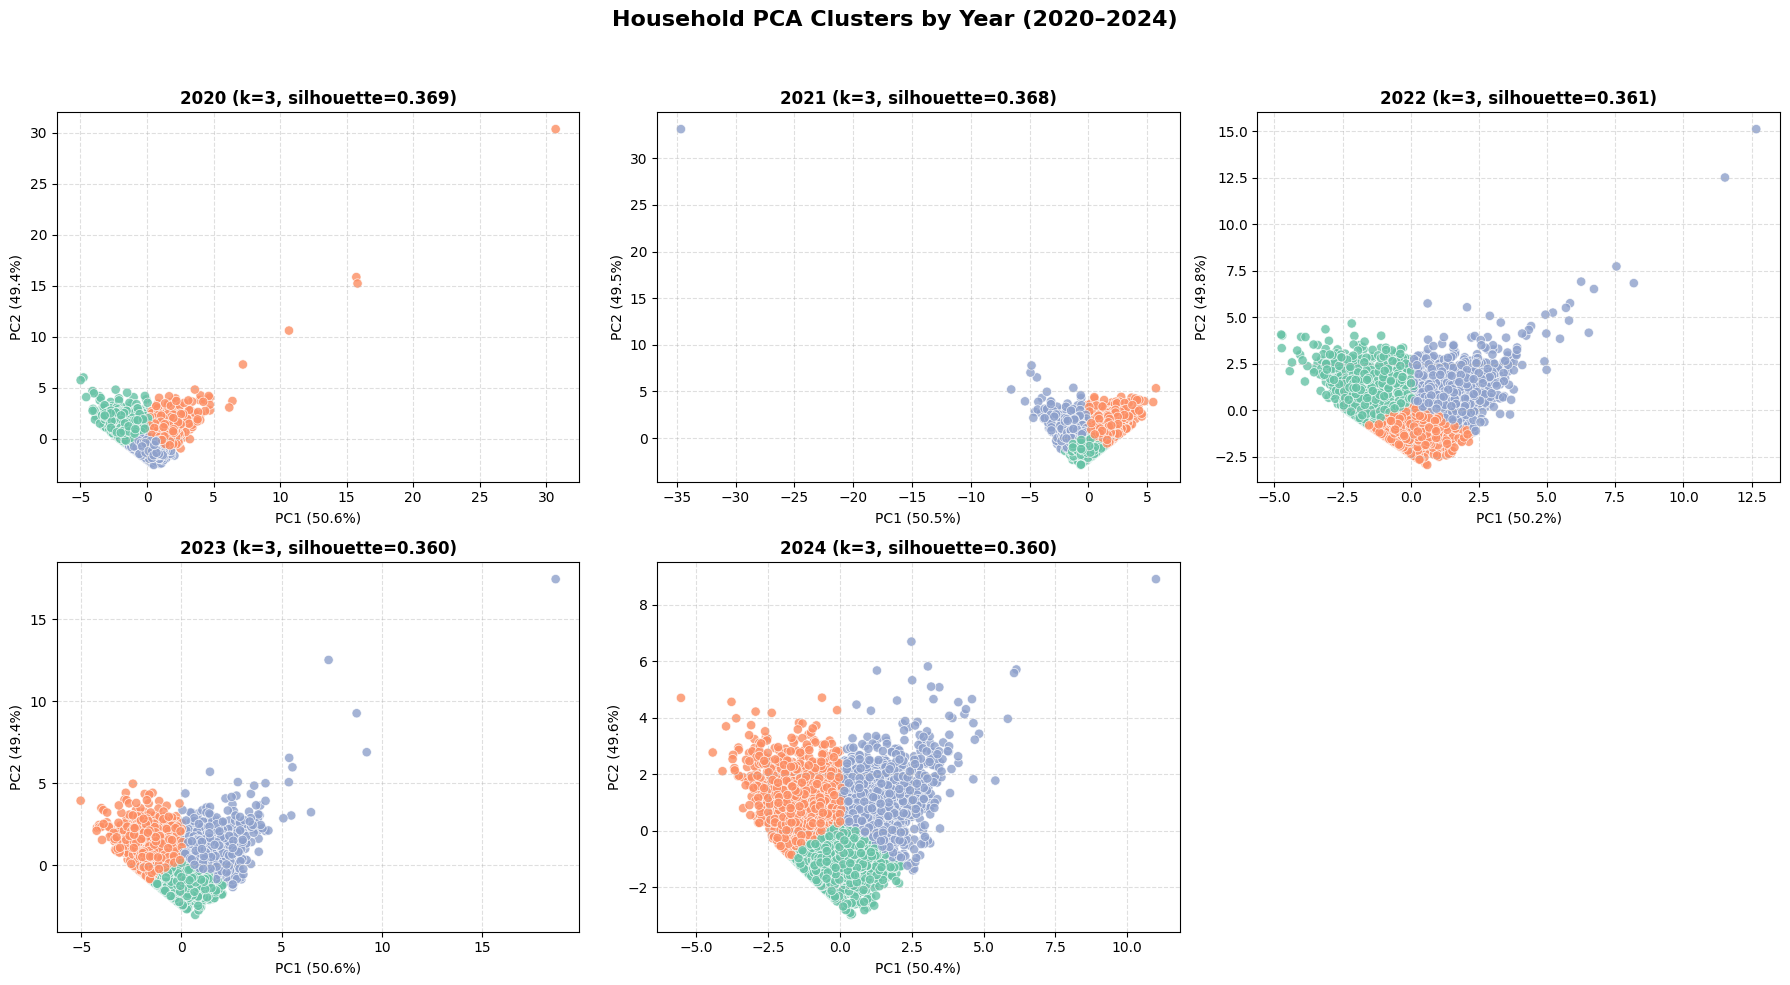

In [33]:
dfs_by_year = {
    2020: hh20_me,
    2021: hh21_me,
    2022: hh22_me,
    2023: hh23_me,
    2024: hh24_me,
}

features = [
    'average_income', 'total_price'
    ]

results_df, all_clustered_dfs, all_aggregated = cluster_and_plot_all_years(dfs_by_year, features)

In [34]:
all_clustered_dfs[2020].groupby('cluster')['average_income'].mean()

cluster
0    351674.335057
1    730691.403391
2    287381.913567
Name: average_income, dtype: float64

In [35]:
all_clustered_dfs[2020]

,household_code,year,total_income,average_income,median_income,most_frequent_person,most_frequent_residence,total_price,average_price,median_price,...,average_recalc_price,median_recalc_price,total_uplacheno,average_uplacheno,median_uplacheno,total_bought_sold,num_records,average_num_of_people,territory_code,cluster
0,61,2020,519544,259772.000000,259772.0,1,2,184991.0,837.063348,546.0,...,1.508108,0.0,100821.0,446.110619,100.0,173.945,230,3.921739,11,2
1,100,2020,918600,306200.000000,432008.0,2,2,189856.0,963.736041,664.0,...,0.777108,0.0,109692.0,574.303665,197.0,164.418,202,3.580000,11,2
2,125,2020,519241,173080.333333,9241.0,1,2,72752.0,920.911392,754.0,...,0.863014,0.0,37740.0,465.925926,160.0,101.790,86,3.686047,11,2
3,129,2020,1507000,502333.333333,615000.0,2,1,140975.0,791.994382,571.0,...,1.379747,0.0,69888.0,401.655172,96.0,144.088,182,3.681319,11,2
4,151,2020,420000,420000.000000,420000.0,1,1,104038.0,722.486111,552.0,...,2.311475,0.0,62050.0,425.000000,106.0,139.356,147,3.523810,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11230,53569,2020,180000,180000.000000,180000.0,2,1,85792.0,675.527559,450.0,...,2.119658,0.0,39119.0,300.915385,56.5,91.254,134,3.895522,11,2
11231,53571,2020,1636630,409157.500000,384850.0,1,1,266017.0,833.909091,613.0,...,1.936620,0.0,141384.0,441.825000,128.5,254.203,331,3.500000,11,0
11232,53572,2020,804612,268204.000000,300000.0,2,1,86851.0,877.282828,608.0,...,1.048780,0.0,51354.0,503.470588,117.5,73.961,103,4.203883,11,2
11233,53573,2020,1145472,381824.000000,234972.0,1,1,130202.0,868.013333,636.0,...,1.190083,0.0,72392.0,489.135135,159.0,129.600,151,3.443709,11,2


In [36]:
all_clustered_dfs[2021]

,household_code,year,total_income,average_income,median_income,most_frequent_person,most_frequent_residence,total_price,average_price,median_price,...,average_recalc_price,median_recalc_price,total_uplacheno,average_uplacheno,median_uplacheno,total_bought_sold,num_records,average_num_of_people,territory_code,cluster
0,61,2021,450000,225000.000000,225000.0,2,1,177202.0,868.637255,272.5,...,211.105263,110.0,170558.0,852.790000,538.0,321.046,205,3.740196,11,0
1,100,2021,1646919,548973.000000,210000.0,1,1,176597.0,821.381395,171.0,...,194.052910,126.0,177676.0,793.196429,539.0,351.577,230,3.713043,11,2
2,104,2021,1588141,529380.333333,598200.0,1,2,100514.0,712.865248,227.0,...,263.072727,107.0,135888.0,930.739726,649.0,242.535,150,3.360000,11,2
3,125,2021,607912,303956.000000,303956.0,1,1,151200.0,1057.342657,384.0,...,170.289062,92.5,151753.0,1061.209790,792.0,233.139,152,3.848684,11,0
4,129,2021,1214027,303506.750000,324000.0,2,2,147296.0,688.299065,149.0,...,178.866310,99.0,176188.0,827.173709,597.0,363.157,227,3.696035,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11467,57619,2021,460396,460396.000000,460396.0,1,1,74030.0,831.797753,197.0,...,147.532468,92.0,83906.0,932.288889,662.0,176.248,96,3.864583,71,0
11468,57620,2021,1132000,377333.333333,390000.0,2,1,234882.0,785.558528,277.0,...,165.108871,77.0,251026.0,865.606897,654.0,516.776,304,3.799342,27,1
11469,57621,2021,912627,304209.000000,184000.0,1,2,100375.0,597.470238,163.0,...,196.052980,101.0,116679.0,694.517857,433.0,248.079,176,3.767045,75,0
11470,57622,2021,2600200,650050.000000,565100.0,1,2,279987.0,762.907357,188.0,...,181.696078,88.5,295964.0,810.860274,546.0,590.109,379,3.744063,11,1


In [37]:
# Inflation coefficients (relative to 2020)
inflation_coef = {
    2020: 1.00,
    2021: 1.08,
    2022: 1.30,
    2023: 1.43,
    2024: 1.55
}

# Loop through all years and adjust values
for year, df in all_clustered_dfs.items():
    coef = inflation_coef.get(year, 1)  # default 1 if year not in dict
    
    for col in ['total_income', 'average_income', 'total_price']:
        if col in df.columns:
            # Create real (deflated) version of each column
            df[col + '_real'] = df[col] / coef

    # Update the dictionary with adjusted DataFrame
    all_clustered_dfs[year] = df

print("✅ Inflation adjustment applied to total_income, average_income, and total_price across all years.")


✅ Inflation adjustment applied to total_income, average_income, and total_price across all years.


In [38]:
def reassign_cluster(year):
    cluster_means_2020 = all_clustered_dfs[year].groupby('cluster')['average_income'].mean()
    sorted_clusters = cluster_means_2020.sort_values()
    cluster_mapping = {old: new for old, new in zip(sorted_clusters.index, [1, 2, 3])}

    all_clustered_dfs[year]['reassigned_cluster'] = all_clustered_dfs[year]['cluster'].map(cluster_mapping)
    return all_clustered_dfs[year]

In [39]:
all_agg_list = []

# Loop through all available years
for year in range(2020, 2025):
    # Get the correct year's data
    agg = all_aggregated[year].reset_index()
    agg['year'] = year

    # --- Step 1: Ensure consistent cluster assignment ---
    # Recalculate clusters based on average_income for that year
    # 3 clusters: 1 = below avg, 2 = middle, 3 = above avg

    # Handle cases with fewer unique values safely
    try:
        agg['reassigned_cluster'] = pd.qcut(
            agg['average_income'],
            q=3,
            labels=[1, 2, 3]
        ).astype(int)
    except ValueError:
        # fallback if qcut fails (e.g., too few unique values)
        agg['reassigned_cluster'] = pd.cut(
            agg['average_income'],
            bins=3,
            labels=[1, 2, 3]
        ).astype(int)

    all_agg_list.append(agg)

# Concatenate all years
agg_all = pd.concat(all_agg_list, ignore_index=True)

In [40]:
agg_all['year'] = agg_all['year'].astype(int)

# Define monetary columns to adjust
monetary_cols = ['average_income', 'total_price', 'average_price', 'average_recalc_price']

# Apply deflation (convert all values to 2020 constant prices)
for col in monetary_cols:
    if col in agg_all.columns:
        agg_all[col + '_real'] = agg_all.apply(lambda r: r[col] / inflation_coef[r['year']], axis=1)

# Optional: round for readability
agg_all[[c for c in agg_all.columns if c.endswith('_real')]] = agg_all[[c for c in agg_all.columns if c.endswith('_real')]].round(2)

In [41]:
def reassign_cluster(year):
    cluster_means_2020 = all_clustered_dfs[year].groupby('cluster')['average_income'].mean()
    sorted_clusters = cluster_means_2020.sort_values()
    cluster_mapping = {old: new for old, new in zip(sorted_clusters.index, [1, 2, 3])}

    all_clustered_dfs[year]['reassigned_cluster'] = all_clustered_dfs[year]['cluster'].map(cluster_mapping)
    return all_clustered_dfs[year]

In [42]:
for i in [2020,2021,2022,2023,2024]:
    all_clustered_dfs[i] = reassign_cluster(i)

In [43]:
regions = list(all_clustered_dfs[2020]['territory_code'].unique())

In [44]:
households_per_year = {
    year: set(df['household_code'].unique())
    for year, df in all_clustered_dfs.items()
}

# Step 2: find intersection (households present in all years)
households_all_years = list(set.intersection(*households_per_year.values()))

print(f"✅ Number of households present in all years: {len(households_all_years)}")
print(f"Example household IDs: {households_all_years[:10]}")

✅ Number of households present in all years: 560
Example household IDs: [np.int64(51205), np.int64(26629), np.int64(40977), np.int64(40980), np.int64(26644), np.int64(51227), np.int64(32798), np.int64(51232), np.int64(41003), np.int64(51248)]


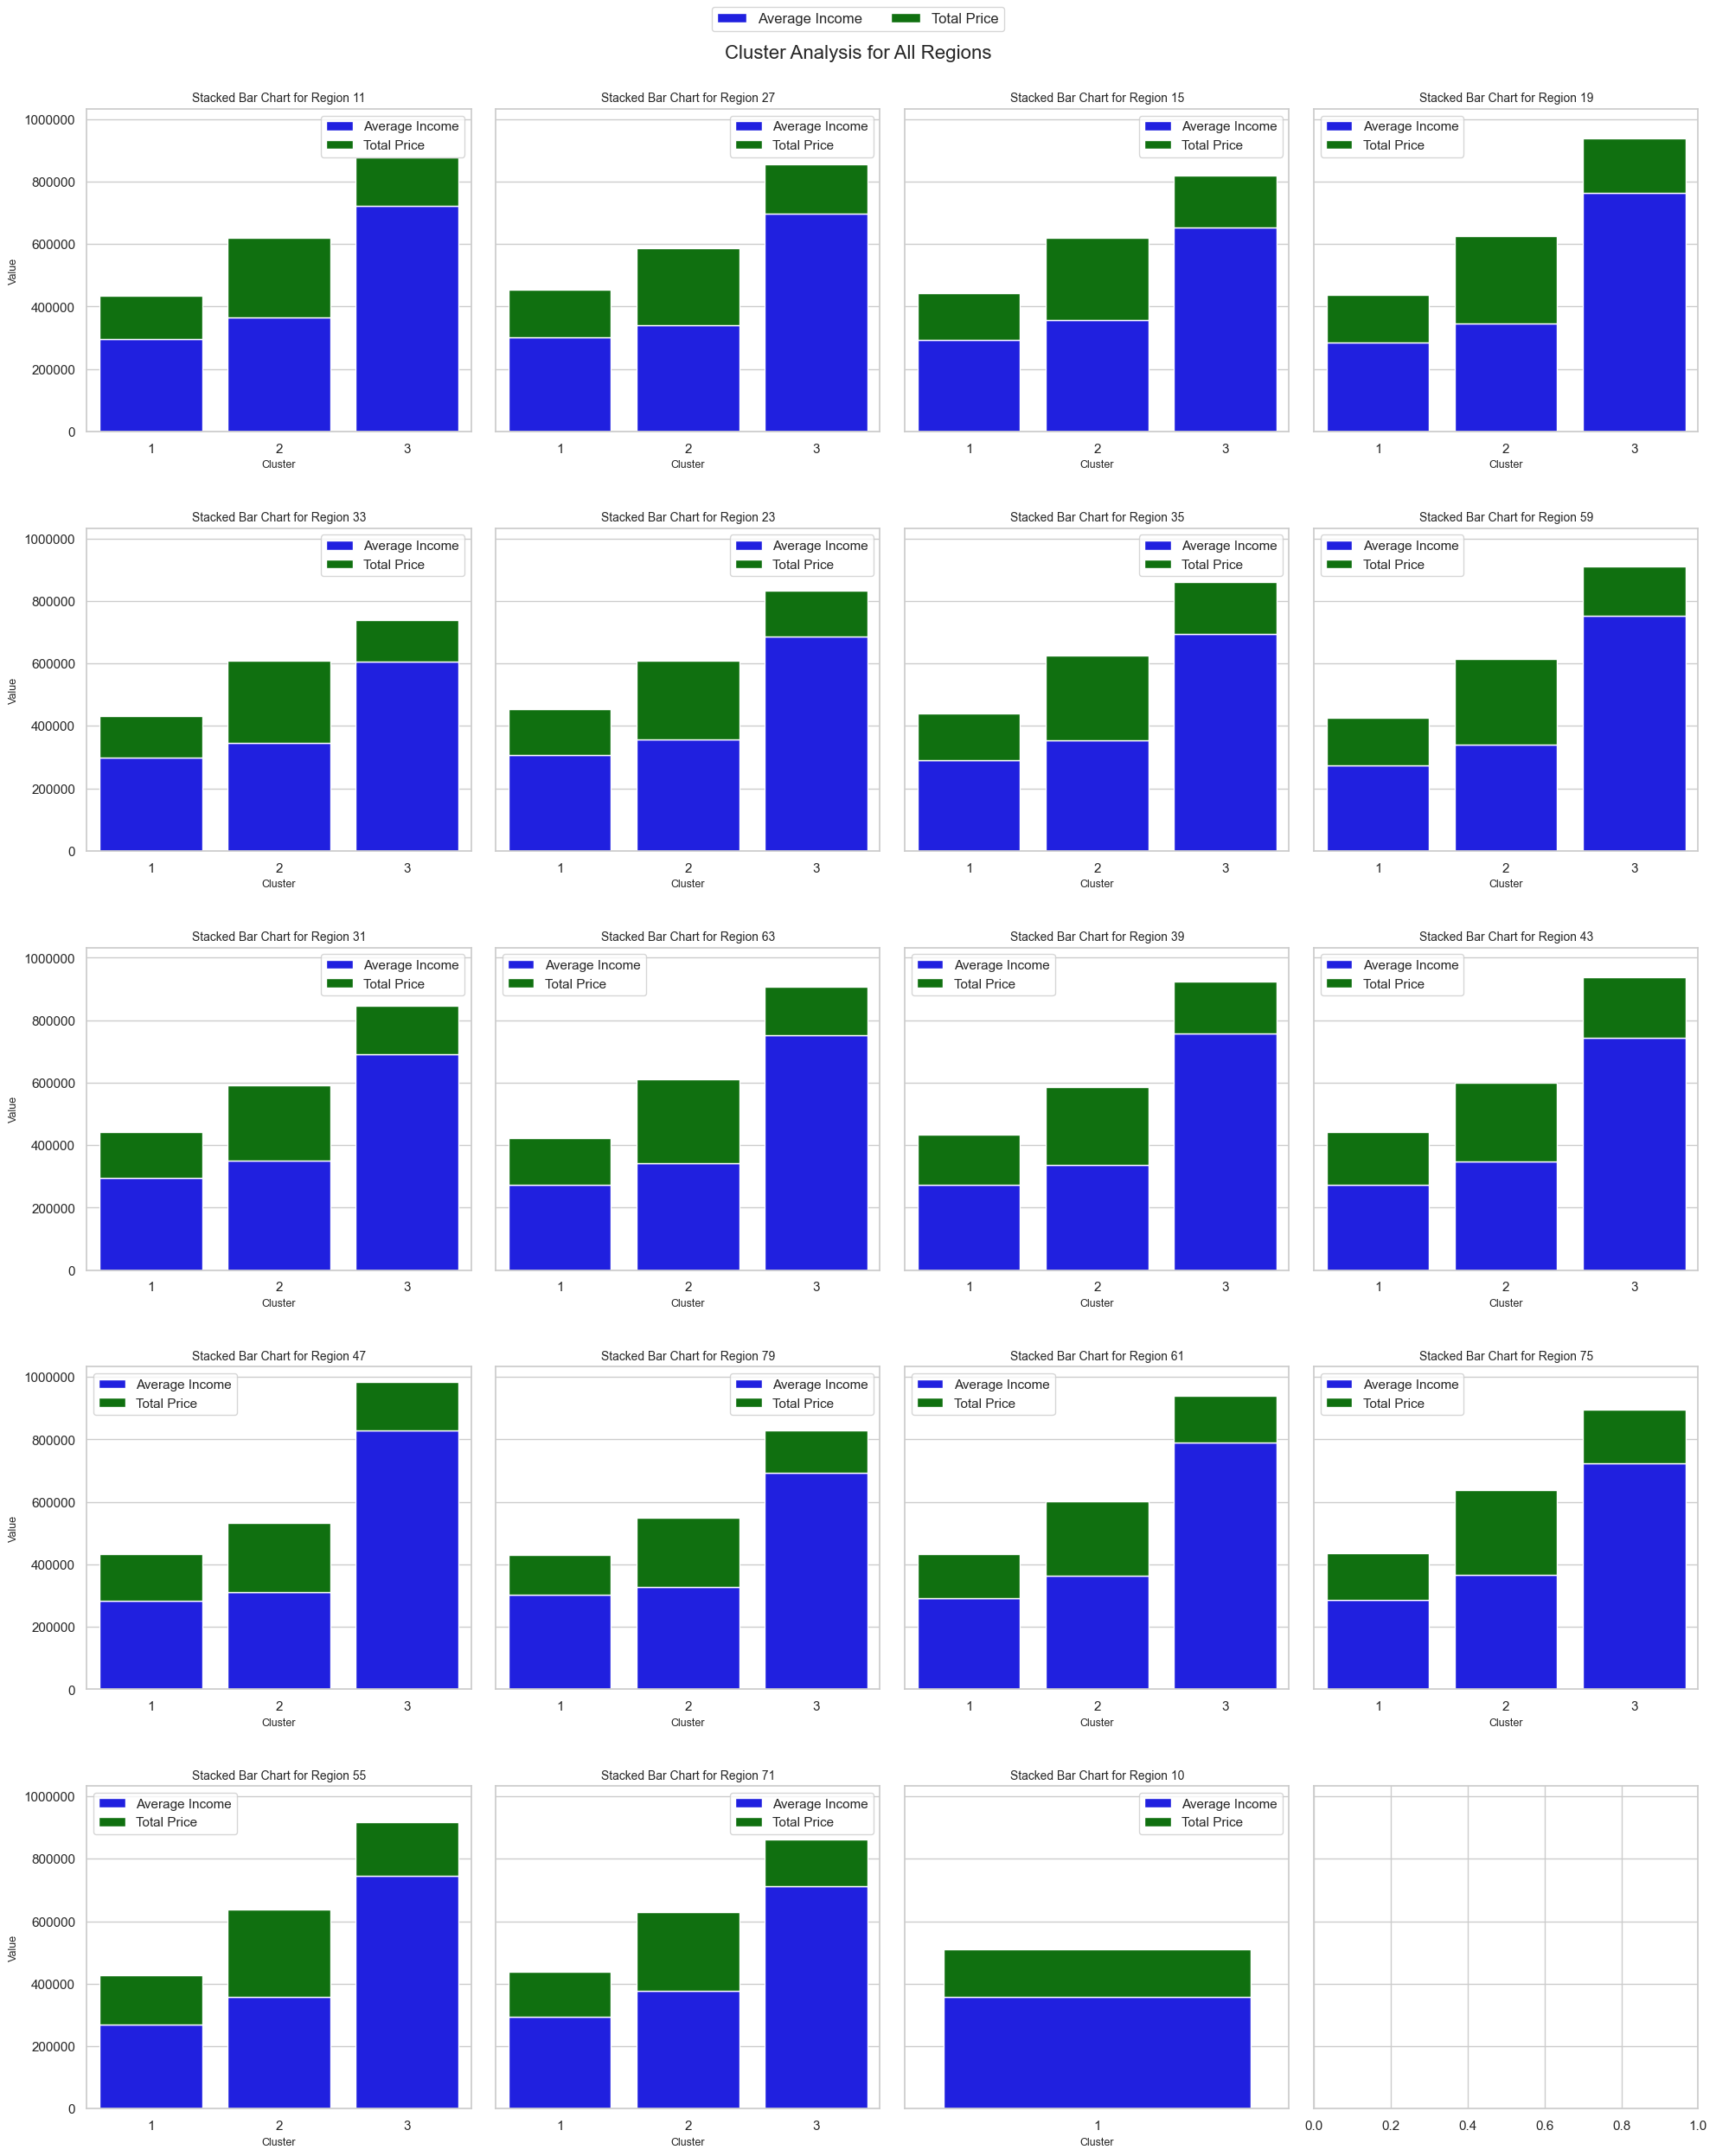

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace with your actual data)
regions = all_clustered_dfs[2020]['territory_code'].unique()

# Set the style for the plots
sns.set(style="whitegrid")

# Calculate number of rows and columns for subplots
n_cols = 4  # Number of columns for subplots (increase this for more compact display)
n_rows = (len(regions) + n_cols - 1) // n_cols  # Dynamically calculate rows

# Create a figure with subplots for all regions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharey=True)

# Flatten axes array for easier iteration (if it's a 2D grid)
axes = axes.flatten()

# Plotting for each region
for idx, region in enumerate(regions):
    # Filter the data for the specific region
    region_df = all_clustered_dfs[2020][all_clustered_dfs[2020]['territory_code'] == region]
    
    # Get the mean values for average_income and total_price by cluster
    cluster_data = region_df.groupby('reassigned_cluster')[['average_income', 'total_price']].mean()

    # Plot Average Income (bottom part of the stack)
    sns.barplot(x=cluster_data.index, y=cluster_data['average_income'], ax=axes[idx], color='blue', label='Average Income')
    
    # Plot Total Price (stacked on top of average_income)
    sns.barplot(x=cluster_data.index, y=cluster_data['total_price'], ax=axes[idx], color='green', 
                bottom=cluster_data['average_income'], label='Total Price')
    
    # Set titles and labels
    axes[idx].set_title(f'Stacked Bar Chart for Region {region}', fontsize=10)
    axes[idx].set_xlabel('Cluster', fontsize=9)
    axes[idx].set_ylabel('Value', fontsize=9)

    # Set Y-axis to integer format to avoid decimals
    axes[idx].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

# Add legend for each subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12)

# Adjust layout for better visibility and avoid overlap
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)  # Adjust the spacing and the title

# Add the main title
fig.suptitle('Cluster Analysis for All Regions', fontsize=16)

# Show the plot
plt.show()

In [46]:
region_summary_df = all_clustered_dfs[2020].groupby(['territory_code', 'reassigned_cluster'])[['average_income', 'total_price']].mean().reset_index()

In [47]:
dfs = []

# Loop over the years and process the data for each year
for year in range(2020, 2025):  # Adjust this range if you have more years

    year_df = all_clustered_dfs[year].groupby(['territory_code', 'reassigned_cluster']).agg(
        {'average_income': 'mean', 'total_price': 'mean', 'average_income_real': 'mean', 'total_price_real': 'mean', 'household_code': 'count'}
        ).reset_index()
    
    # Add a column for the year to track it in the final DataFrame
    year_df['year'] = year
    
    # Append the year DataFrame to the list
    dfs.append(year_df)

# Concatenate all the year-wise DataFrames into one DataFrame
final_df = pd.concat(dfs, axis=0, ignore_index=True)

# Optionally, sort the DataFrame by 'territory_code' and 'reassigned_cluster' for better readability
final_df = final_df.sort_values(by=['territory_code', 'reassigned_cluster', 'year']).reset_index(drop=True)

In [48]:
dfs = []

# Loop over the years and process the data for each year
for year in range(2020, 2025):  # Adjust this range if you have more years
    # Group by 'territory_code' and 'reassigned_cluster' for each year
    df_year = all_clustered_dfs[year]
    df_year = df_year[df_year['household_code'].isin(households_all_years)]
    year_df = df_year.groupby(['territory_code', 'reassigned_cluster']).agg(
        {'average_income': 'mean', 'total_price': 'mean', 'average_income_real': 'mean', 'total_price_real': 'mean', 'household_code': 'count'}
        ).reset_index()
    
    # Add a column for the year to track it in the final DataFrame
    year_df['year'] = year
    
    # Append the year DataFrame to the list
    dfs.append(year_df)

# Concatenate all the year-wise DataFrames into one DataFrame
final_allhh_df = pd.concat(dfs, axis=0, ignore_index=True)

# Optionally, sort the DataFrame by 'territory_code' and 'reassigned_cluster' for better readability
final_allhh_df = final_allhh_df.sort_values(by=['territory_code', 'reassigned_cluster', 'year']).reset_index(drop=True)

In [49]:
dfs = []

# Loop over the years and process the data for each year
for year in range(2020, 2025):  # Adjust this range if you have more years
    # Group by 'territory_code' and 'reassigned_cluster' for each year
    df_year = all_clustered_dfs[year]
    df_year = df_year[df_year['household_code'].isin(households_all_years)]
    year_df = df_year.groupby(['reassigned_cluster']).agg(
        {'average_income': 'mean', 'total_price': 'mean', 'average_income_real': 'mean', 'total_price_real': 'mean', 'household_code': 'count'}
        ).reset_index()
    
    # Add a column for the year to track it in the final DataFrame
    year_df['year'] = year
    
    # Append the year DataFrame to the list
    dfs.append(year_df)

# Concatenate all the year-wise DataFrames into one DataFrame
final_allhh_clusters_df = pd.concat(dfs, axis=0, ignore_index=True)

# Optionally, sort the DataFrame by 'territory_code' and 'reassigned_cluster' for better readability
final_allhh_clusters_df = final_allhh_clusters_df.sort_values(by=['reassigned_cluster', 'year']).reset_index(drop=True)

In [50]:
base = final_df[final_df['year'] == 2020][
    ['territory_code', 'reassigned_cluster', 'average_income', 'total_price', 'average_income_real', 'total_price_real', 'household_code']
].rename(
    columns={
        'average_income': 'base_income_2020',
        'average_income_real': 'base_income_2020_real',
        'total_price': 'base_price_2020',
        'total_price_real': 'base_price_2020_real',
        'household_code': 'base_count_2020'
    }
)

In [51]:
basea_llhh_allclusters = final_allhh_clusters_df[final_allhh_clusters_df['year'] == 2020][
    ['reassigned_cluster', 'average_income', 'total_price', 'average_income_real', 'total_price_real', 'household_code']
].rename(
    columns={
        'average_income': 'base_income_2020',
        'average_income_real': 'base_income_2020_real',
        'total_price': 'base_price_2020',
        'total_price_real': 'base_price_2020_real',
        'household_code': 'base_count_2020',
    }
)

In [52]:
basea_llhh = final_allhh_df[final_allhh_df['year'] == 2020][
    ['territory_code', 'reassigned_cluster', 'average_income', 'total_price', 'average_income_real', 'total_price_real', 'household_code']
].rename(
    columns={
        'average_income': 'base_income_2020',
        'average_income_real': 'base_income_2020_real',
        'total_price': 'base_price_2020',
        'total_price_real': 'base_price_2020_real',
        'household_code': 'base_count_2020',
    }
)

In [53]:
final_df = final_df.merge(base, on=['territory_code', 'reassigned_cluster'], how='left')

In [54]:
final_allhh_clusters_df = final_allhh_clusters_df.merge(basea_llhh_allclusters, on='reassigned_cluster', how='left')

In [55]:
final_allhh_df = final_allhh_df.merge(basea_llhh, on=['territory_code', 'reassigned_cluster'], how='left')

In [56]:
# Step 3: calculate percentage change relative to 2020
final_df['income_pct_change'] = (
    (final_df['average_income_real'] - final_df['base_income_2020_real'])
    / final_df['base_income_2020_real']
) * 100

final_df['price_pct_change'] = (
    (final_df['total_price_real'] - final_df['base_price_2020_real'])
    / final_df['base_price_2020_real']
) * 100

final_df['count_pct_change'] = (
    (final_df['household_code'] - final_df['base_count_2020'])
    / final_df['base_count_2020']
) * 100

# Step 4: (optional) round results for neatness
final_df[['income_pct_change', 'price_pct_change', 'count_pct_change']] = final_df[
    ['income_pct_change', 'price_pct_change', 'count_pct_change']
].round(2)

In [57]:
# Step 3: calculate percentage change relative to 2020
final_allhh_clusters_df['income_pct_change'] = (
    (final_allhh_clusters_df['average_income_real'] - final_allhh_clusters_df['base_income_2020_real'])
    / final_allhh_clusters_df['base_income_2020_real']
) * 100

final_allhh_clusters_df['price_pct_change'] = (
    (final_allhh_clusters_df['total_price_real'] - final_allhh_clusters_df['base_price_2020_real'])
    / final_allhh_clusters_df['base_price_2020_real']
) * 100

final_allhh_clusters_df['count_pct_change'] = (
    (final_allhh_clusters_df['household_code'] - final_allhh_clusters_df['base_count_2020'])
    / final_allhh_clusters_df['base_count_2020']
) * 100

# Step 4: (optional) round results for neatness
final_allhh_clusters_df[['income_pct_change', 'price_pct_change', 'count_pct_change']] = final_allhh_clusters_df[
    ['income_pct_change', 'price_pct_change', 'count_pct_change']
].round(2)

In [58]:
# Step 3: calculate percentage change relative to 2020
final_allhh_df['income_pct_change'] = (
    (final_allhh_df['average_income_real'] - final_allhh_df['base_income_2020_real'])
    / final_allhh_df['base_income_2020_real']
) * 100

final_allhh_df['price_pct_change'] = (
    (final_allhh_df['total_price_real'] - final_allhh_df['base_price_2020_real'])
    / final_allhh_df['base_price_2020_real']
) * 100

final_allhh_df['count_pct_change'] = (
    (final_allhh_df['household_code'] - final_allhh_df['base_count_2020'])
    / final_allhh_df['base_count_2020']
) * 100

# Step 4: (optional) round results for neatness
final_allhh_df[['income_pct_change', 'price_pct_change', 'count_pct_change']] = final_allhh_df[
    ['income_pct_change', 'price_pct_change', 'count_pct_change']
].round(2)

In [59]:
oblast_to_region = {
    10: "Abay",
    11: "Akmola",
    15: "Aktobe",
    19: "Almaty",
    23: "Atyrau",
    27: "West Kazakhstan",
    31: "Jambyl",
    33: 'Zhetysu',
    35: "Karagandy",
    39: "Kostanay",
    43: "Kyzylorda",
    47: "Mangystau",
    55: "Pavlodar",
    59: "North-Kazakhstan",
    61: "Turkistan",
    62: "Ulytau",
    63: "East-Kazakhstan",
    71: "Astana",
    75: "Almaty city",
    79: "Shymkent"
}

In [60]:
li = []
for i in [1,2,3]:
    ap = final_allhh_clusters_df[final_allhh_clusters_df['reassigned_cluster']==i].household_code.pct_change().to_list()
    li.append(ap)
li = li[0] + li[1]+ li[2]

In [61]:
li_inc = []
for i in [1,2,3]:
    ap = final_allhh_clusters_df[final_allhh_clusters_df['reassigned_cluster']==i].average_income_real.pct_change().to_list()
    li_inc.append(ap)
li_inc = li_inc[0] + li_inc[1]+ li_inc[2]

In [62]:
li_exp = []
for i in [1,2,3]:
    ap = final_allhh_clusters_df[final_allhh_clusters_df['reassigned_cluster']==i].total_price_real.pct_change().to_list()
    li_exp.append(ap)
li_exp = li_exp[0] + li_exp[1]+ li_exp[2]

In [63]:
final_allhh_clusters_df['count_pct_change_yearly'] = li
final_allhh_clusters_df['income_pct_change_yearly'] = li_inc
final_allhh_clusters_df['price_pct_change_yearly'] = li_exp

In [64]:
final_allhh_clusters_df['count_pct_change_yearly'] = final_allhh_clusters_df['count_pct_change_yearly'].fillna(0)
final_allhh_clusters_df['income_pct_change_yearly'] = final_allhh_clusters_df['income_pct_change_yearly'].fillna(0)
final_allhh_clusters_df['price_pct_change_yearly'] = final_allhh_clusters_df['price_pct_change_yearly'].fillna(0)

In [65]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- 1. Подготовка данных ---
# Убедимся, что колонки нужных типов
agg_all['reassigned_cluster'] = agg_all['reassigned_cluster'].astype(int)
agg_all['average_income_real'] = agg_all['average_income_real'].astype(float)
agg_all['total_price_real'] = agg_all['total_price_real'].astype(float)

# --- 2. ANOVA по average_income_real ---
anova_income = stats.f_oneway(
    *[group['average_income_real'].dropna() for _, group in agg_all.groupby('reassigned_cluster')]
)

# --- 3. ANOVA по total_price_real ---
anova_price = stats.f_oneway(
    *[group['total_price_real'].dropna() for _, group in agg_all.groupby('reassigned_cluster')]
)

# --- 4. Альтернативный (более подробный) вариант через statsmodels ---
model = ols('average_income_real ~ C(reassigned_cluster)', data=agg_all).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("🔹 ANOVA results (Income by Cluster)")
print(anova_table)
print("\nF =", anova_income.statistic, ", p =", anova_income.pvalue)
print("\n🔹 ANOVA results (Total Price by Cluster)")
print("F =", anova_price.statistic, ", p =", anova_price.pvalue)

# --- 5. Интерпретация на основе p-values ---
alpha = 0.05

🔹 ANOVA results (Income by Cluster)
                             sum_sq    df          F    PR(>F)
C(reassigned_cluster)  3.474917e+11   2.0  35.587282  0.000009
Residual               5.858695e+10  12.0        NaN       NaN

F = 35.58728223962464 , p = 9.018706701030624e-06

🔹 ANOVA results (Total Price by Cluster)
F = 386.79856904399014 , p = 1.270246831681959e-11


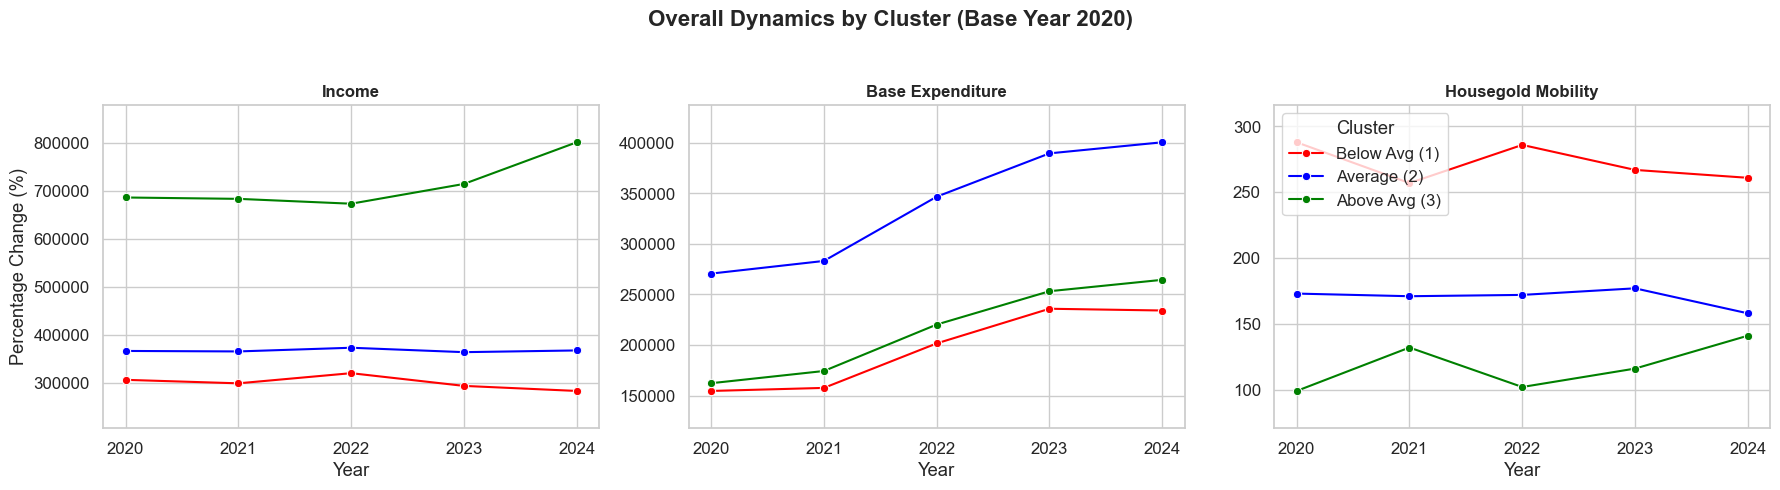

In [66]:
# Seaborn style and colors
sns.set(style="whitegrid", font_scale=1.1)

final_allhh_clusters_df['year'] = final_allhh_clusters_df['year'].astype(str)
final_allhh_clusters_df['reassigned_cluster'] = final_allhh_clusters_df['reassigned_cluster'].astype(str)
cluster_colors = {
    '1': 'red',    # below average
    '2': 'blue',   # average
    '3': 'green'   # above average
}

# Define metrics and their titles
metrics = [
    ('average_income', 'Income'),
    ('total_price', 'Base Expenditure'),
    ('household_code', 'Housegold Mobility'),
]


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
fig.suptitle("Overall Dynamics by Cluster (Base Year 2020)",
                fontsize=16, fontweight='bold')

for i, (metric_col, title) in enumerate(metrics):
    ax = axes[i]

    # Draw lines by cluster
    sns.lineplot(
        data=final_allhh_clusters_df,
        x='year',
        y=metric_col,
        hue='reassigned_cluster',
        palette=cluster_colors,
        marker='o',
        ax=ax
    )

    # --- Dynamically set y limits ---
    y_min = final_allhh_clusters_df[metric_col].min()
    y_max = final_allhh_clusters_df[metric_col].max()
    y_range = y_max - y_min
    margin = y_range * 0.15 if y_range > 0 else 10  # 15% margin
    ax.set_ylim(y_min - margin, y_max + margin)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Year")
    ax.set_ylabel("Percentage Change (%)" if i == 0 else "")
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Show legend only in the last subplot
    if i == 2:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles,
            ['Below Avg (1)', 'Average (2)', 'Above Avg (3)'],
            title="Cluster",
            loc='upper left',
            frameon=True
        )
    else:
        ax.get_legend().remove()

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [67]:
# # VISUALS WITH THE HOUSEHOLDS THAT ARE PRESENT IN ALL YEARS
# sns.set(style="whitegrid", font_scale=1.1)

# final_allhh_df['year'] = final_allhh_df['year'].astype(str)
# final_allhh_df['territory_code'] = final_allhh_df['territory_code'].astype(str)
# final_allhh_df['reassigned_cluster'] = final_allhh_df['reassigned_cluster'].astype(str)
# cluster_colors = {
#     '1': 'red',    # below average
#     '2': 'blue',   # average
#     '3': 'green'   # above average
# }

# # Define metrics and their titles
# metrics = [
#     ('income_pct_change', 'Real Income Change (%)'),
#     ('price_pct_change', 'Real Base Expenditure Change (%)'),
#     ('count_pct_change', 'Real Household Mobility Change (%)'),
# ]

# territories = sorted(final_allhh_df['territory_code'].unique())

# for territory in territories:
#     subset = final_allhh_df[final_allhh_df['territory_code'] == territory]

#     fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
#     fig.suptitle(f"{oblast_to_region[int(territory)]}: Dynamics by Cluster (Base Year 2020)",
#                  fontsize=16, fontweight='bold')

#     for i, (metric_col, title) in enumerate(metrics):
#         ax = axes[i]

#         # Draw lines by cluster
#         sns.lineplot(
#             data=subset,
#             x='year',
#             y=metric_col,
#             hue='reassigned_cluster',
#             palette=cluster_colors,
#             marker='o',
#             ax=ax
#         )

#         # --- Dynamically set y limits ---
#         y_min = subset[metric_col].min()
#         y_max = subset[metric_col].max()
#         y_range = y_max - y_min
#         margin = y_range * 0.15 if y_range > 0 else 10  # 15% margin
#         ax.set_ylim(y_min - margin, y_max + margin)

#         ax.set_title(title, fontsize=12, fontweight='bold')
#         ax.set_xlabel("Year")
#         ax.set_ylabel("Percentage Change (%)")
#         ax.axhline(0, color='gray', linestyle='--', linewidth=1)

#         # Show legend only in the last subplot
#         if i == 2:
#             handles, labels = ax.get_legend_handles_labels()
#             ax.legend(
#                 handles,
#                 ['Below Avg (1)', 'Average (2)', 'Above Avg (3)'],
#                 title="Cluster",
#                 loc='upper left',
#                 frameon=True
#             )
#         else:
#             ax.get_legend().remove()

#     fig.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()

In [68]:
# # ALL HOUSEHOLDS VISUAL
# sns.set(style="whitegrid", font_scale=1.1)

# final_df['year'] = final_df['year'].astype(str)
# final_df['territory_code'] = final_df['territory_code'].astype(str)
# final_df['reassigned_cluster'] = final_df['reassigned_cluster'].astype(str)
# cluster_colors = {
#     '1': 'red',    # below average
#     '2': 'blue',   # average
#     '3': 'green'   # above average
# }

# # Define metrics and their titles
# metrics = [
#     ('average_income_real', 'Real Income'),
#     ('total_price_real', 'Real Base Expenditure'),
#     ('household_code', 'Housegold Mobility'),
# ]

# territories = sorted(final_df['territory_code'].unique())

# for territory in territories:
#     subset = final_df[final_df['territory_code'] == territory]

#     fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
#     fig.suptitle(f"Territory {oblast_to_region[int(territory)]}: Dynamics by Cluster (Base Year 2020)",
#                  fontsize=16, fontweight='bold')

#     for i, (metric_col, title) in enumerate(metrics):
#         ax = axes[i]

#         # Draw lines by cluster
#         sns.lineplot(
#             data=subset,
#             x='year',
#             y=metric_col,
#             hue='reassigned_cluster',
#             palette=cluster_colors,
#             marker='o',
#             ax=ax
#         )

#         # --- Dynamically set y limits ---
#         y_min = subset[metric_col].min()
#         y_max = subset[metric_col].max()
#         y_range = y_max - y_min
#         margin = y_range * 0.15 if y_range > 0 else 10  # 15% margin
#         ax.set_ylim(y_min - margin, y_max + margin)

#         ax.set_title(title, fontsize=12, fontweight='bold')
#         ax.set_xlabel("Year")
#         ax.set_ylabel("Value (tenge)" if i == 0 else "")
#         ax.axhline(0, color='gray', linestyle='--', linewidth=1)

#         # Show legend only in the last subplot
#         if i == 2:
#             handles, labels = ax.get_legend_handles_labels()
#             ax.legend(
#                 handles,
#                 ['Below Avg (1)', 'Average (2)', 'Above Avg (3)'],
#                 title="Cluster",
#                 loc='upper left',
#                 frameon=True
#             )
#         else:
#             ax.get_legend().remove()

#     fig.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()

In [70]:
mobility_summary = []

for region, group in final_allhh_df.groupby('territory_code'):
    group = group.sort_values(['household_code', 'year'])
    group['prev_cluster'] = group.groupby('household_code')['reassigned_cluster'].shift()

    upward = (group['reassigned_cluster'] > group['prev_cluster']).mean()
    downward = (group['reassigned_cluster'] < group['prev_cluster']).mean()
    
    mobility_summary.append({
        'region': region,
        'upward_mobility_rate': upward,
        'downward_mobility_rate': downward,
        'net_mobility': upward - downward
    })

mobility_summary = pd.DataFrame(mobility_summary)

In [72]:
# Ensure territory_code is integer type for mapping
mobility_summary['region'] = mobility_summary['region'].astype(int)

# Add region name column using the dictionary
mobility_summary['region_name'] = mobility_summary['region'].map(oblast_to_region)

# Reorder for readability
mobility_summary = mobility_summary[['region', 'region_name'] + 
                              [col for col in mobility_summary.columns if col not in ['region', 'region_name']]]

In [85]:
hh_df = pd.concat([hh20_me, hh21_me, hh22_me, hh23_me, hh24_me])

In [ ]:
trial_df = (
    d003_merged
    .groupby(['territory_code', 'household_code', 'year'], as_index=False) 
    .agg(
        total_price=('price', 'sum'),
        total_recalc_price=('lph_gift_recalc_price', 'sum'),
        total_uplacheno=('uplacheno', 'sum'),
        total_bought_sold=('bought_sold', 'sum'),
        num_records=('product_code', 'count'),
        average_num_of_people=('number_of_people', 'mean'),
    )
)

In [104]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

# --- 1️⃣ Select and clean relevant columns ---
cols = [
    'average_income', 
    'territory_code', 
    'total_price', 
]

hh = final_allhh_df[cols].dropna().copy()

# --- 2️⃣ Convert all to numeric and categorical ---
numeric_cols = ['average_income', 'total_price']
for c in numeric_cols:
    hh[c] = pd.to_numeric(hh[c], errors='coerce')

hh['territory_code'] = hh['territory_code'].astype('category')

# --- 3️⃣ Remove outliers using IQR rule for numeric columns ---
def remove_outliers_iqr(df, columns, factor=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

hh_clean = remove_outliers_iqr(hh, numeric_cols, factor=1.5)
print(f"✅ Remaining observations after outlier removal: {len(hh_clean)} (from {len(hh)})")

# --- 4️⃣ Run regression with dummy encoding for regions ---
model = smf.ols(
    'average_income ~ total_price + C(territory_code)', 
    data=hh_clean
).fit()

# --- 5️⃣ Prepare clean table for presentation ---
results = (
    model.summary2().tables[1]
    .reset_index()
    .rename(columns={'index': 'Variable'})
    .round(4)
)
results['Significance'] = results['P>|t|'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
)

# --- 6️⃣ Print clean formatted output ---
print("\n" + "="*70)
print("          OLS REGRESSION RESULTS — 2020 Households (Outliers Removed)")
print("             Dependent Variable: average_income")
print("="*70)
print(f"Number of Observations: {int(model.nobs)}")
print(f"R-squared: {model.rsquared:.3f} | Adj. R-squared: {model.rsquared_adj:.3f}")
print("-"*70)
print(results.to_string(index=False))
print("-"*70)
print("Significance codes:  *** p<0.01,  ** p<0.05,  * p<0.10")


✅ Remaining observations after outlier removal: 219 (from 229)

          OLS REGRESSION RESULTS — 2020 Households (Outliers Removed)
             Dependent Variable: average_income
Number of Observations: 219
R-squared: 0.056 | Adj. R-squared: -0.019
----------------------------------------------------------------------
               Variable       Coef.   Std.Err.       t  P>|t|       [0.025      0.975] Significance
              Intercept 527675.4356 65569.2464  8.0476 0.0000  398387.4784 656963.3928          ***
C(territory_code)[T.19]  53278.9459 71361.9296  0.7466 0.4562  -87430.8931 193988.7849             
C(territory_code)[T.23] -61254.2432 79648.4381 -0.7691 0.4428 -218303.2320  95794.7457             
C(territory_code)[T.27] -20891.8521 71142.4753 -0.2937 0.7693 -161168.9759 119385.2718             
C(territory_code)[T.31] 171955.0165 89463.7788  1.9221 0.0560   -4447.6392 348357.6723            *
C(territory_code)[T.33] -23461.9734 71137.9656 -0.3298 0.7419 -163730.2051 11

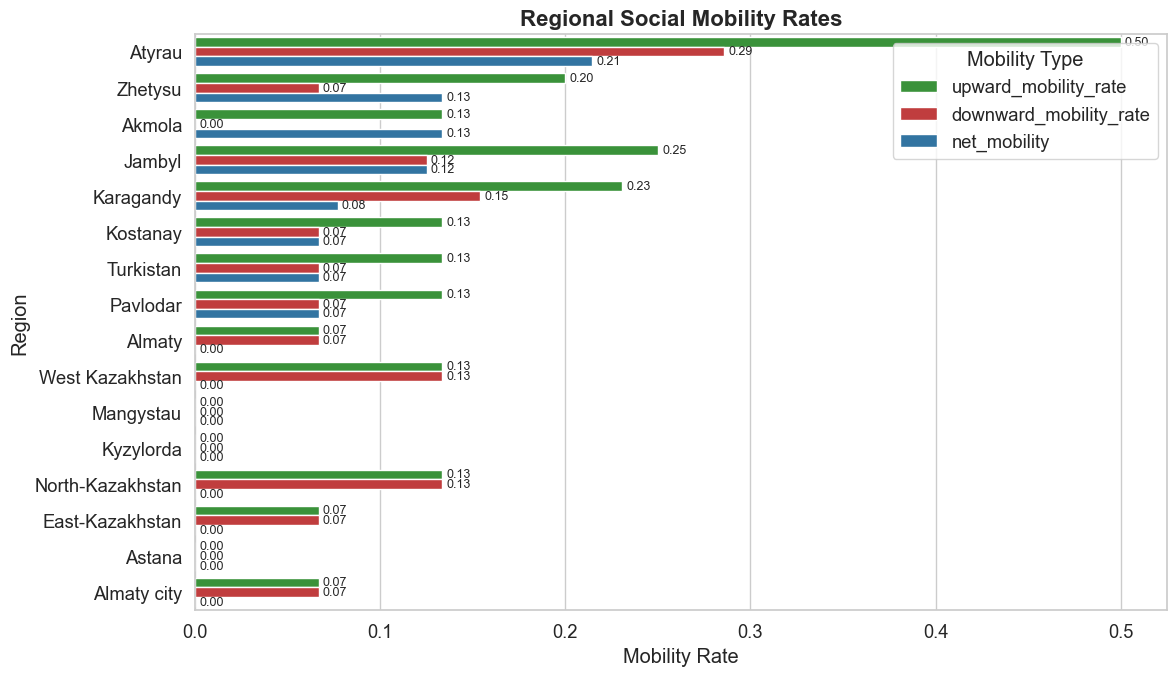

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid", font_scale=1.2)

# Map region codes to names (optional, if you have the dict)
mobility_summary['region_name'] = mobility_summary['region'].map(oblast_to_region)

# Melt into long format for easier plotting
mobility_long = pd.melt(
    mobility_summary,
    id_vars=['region_name'],
    value_vars=['upward_mobility_rate', 'downward_mobility_rate', 'net_mobility'],
    var_name='Mobility Type',
    value_name='Rate'
)

# Sort by net mobility for clearer order
mobility_summary_sorted = mobility_summary.sort_values('net_mobility', ascending=False)
mobility_long['region_name'] = pd.Categorical(
    mobility_long['region_name'],
    categories=mobility_summary_sorted['region_name'],
    ordered=True
)

# --- Plot ---
plt.figure(figsize=(12, 7))
sns.barplot(
    data=mobility_long,
    y='region_name',
    x='Rate',
    hue='Mobility Type',
    palette={'upward_mobility_rate': '#2ca02c',   # green
             'downward_mobility_rate': '#d62728', # red
             'net_mobility': '#1f77b4'}           # blue
)

plt.title("Regional Social Mobility Rates", fontsize=16, fontweight='bold')
plt.xlabel("Mobility Rate")
plt.ylabel("Region")
plt.legend(title="Mobility Type", loc='upper right', frameon=True)

# Add value labels
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.2f", fontsize=9, padding=3)

plt.tight_layout()
plt.show()


In [91]:
agg_all['count_change'] = agg_all.groupby('reassigned_cluster')['count'].pct_change() * 100

In [93]:
agg_all['count_change'] = agg_all['count_change'].fillna(0)

In [96]:
base_count = agg_all[agg_all['year'] == 2020].set_index('reassigned_cluster')['count']

# Calculate the percentage change using the base count from 2020
agg_all['count_change_base'] = agg_all.apply(
    lambda row: (row['count'] - base_count[row['reassigned_cluster']]) / base_count[row['reassigned_cluster']] * 100,
    axis=1
)

<Figure size 1200x600 with 0 Axes>

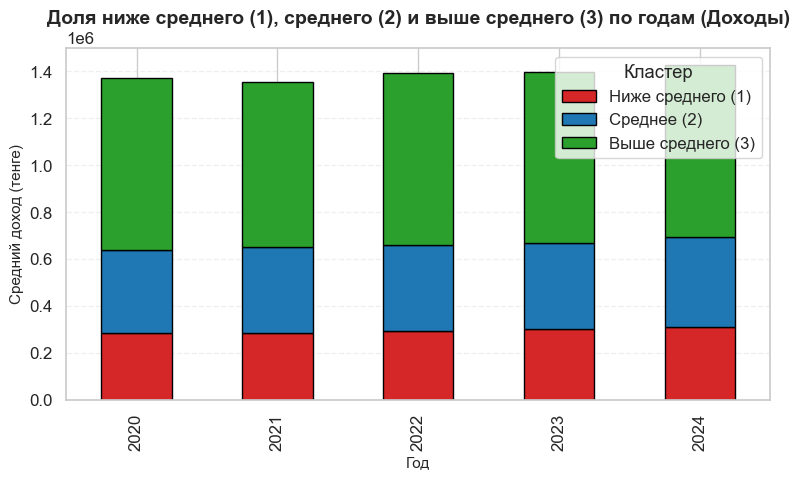

<Figure size 1200x600 with 0 Axes>

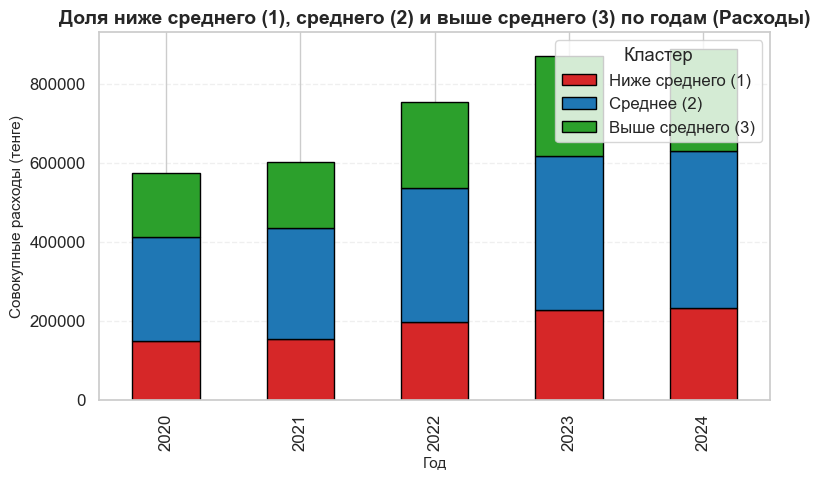

In [99]:
import matplotlib.pyplot as plt

# Define colors for each wealth label (below average, average, above average)
colors = ["#d62728", "#1f77b4", "#2ca02c"]  # red = below average (1), blue = average (2), green = above average (3)

# Pivoting for 'average_income' and 'total_price' separately
pivot_income = agg_all.pivot(index="year", columns="reassigned_cluster", values="average_income")
pivot_price = agg_all.pivot(index="year", columns="reassigned_cluster", values="total_price")

# Ensure the pivot data includes wealth labels 1, 2, and 3 (below average, average, above average)
pivot_income = pivot_income[[1, 2, 3]]  # order: below average (1), average (2), above average (3)
pivot_price = pivot_price[[1, 2, 3]]  # order: below average (1), average (2), above average (3)

# Plot stacked bar chart for average_income
plt.figure(figsize=(12, 6))
pivot_income.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="black",
    figsize=(8, 5)
)
plt.title("Доля ниже среднего (1), среднего (2) и выше среднего (3) по годам (Доходы)", fontsize=14, fontweight="bold")
plt.xlabel("Год", fontsize=11)
plt.ylabel("Средний доход (тенге)", fontsize=11)
plt.legend(["Ниже среднего (1)", "Среднее (2)", "Выше среднего (3)"], title="Кластер", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot stacked bar chart for total_price
plt.figure(figsize=(12, 6))
pivot_price.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="black",
    figsize=(8, 5)
)
plt.title("Доля ниже среднего (1), среднего (2) и выше среднего (3) по годам (Расходы)", fontsize=14, fontweight="bold")
plt.xlabel("Год", fontsize=11)
plt.ylabel("Совокупные расходы (тенге)", fontsize=11)
plt.legend(["Ниже среднего (1)", "Среднее (2)", "Выше среднего (3)"], title="Кластер", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

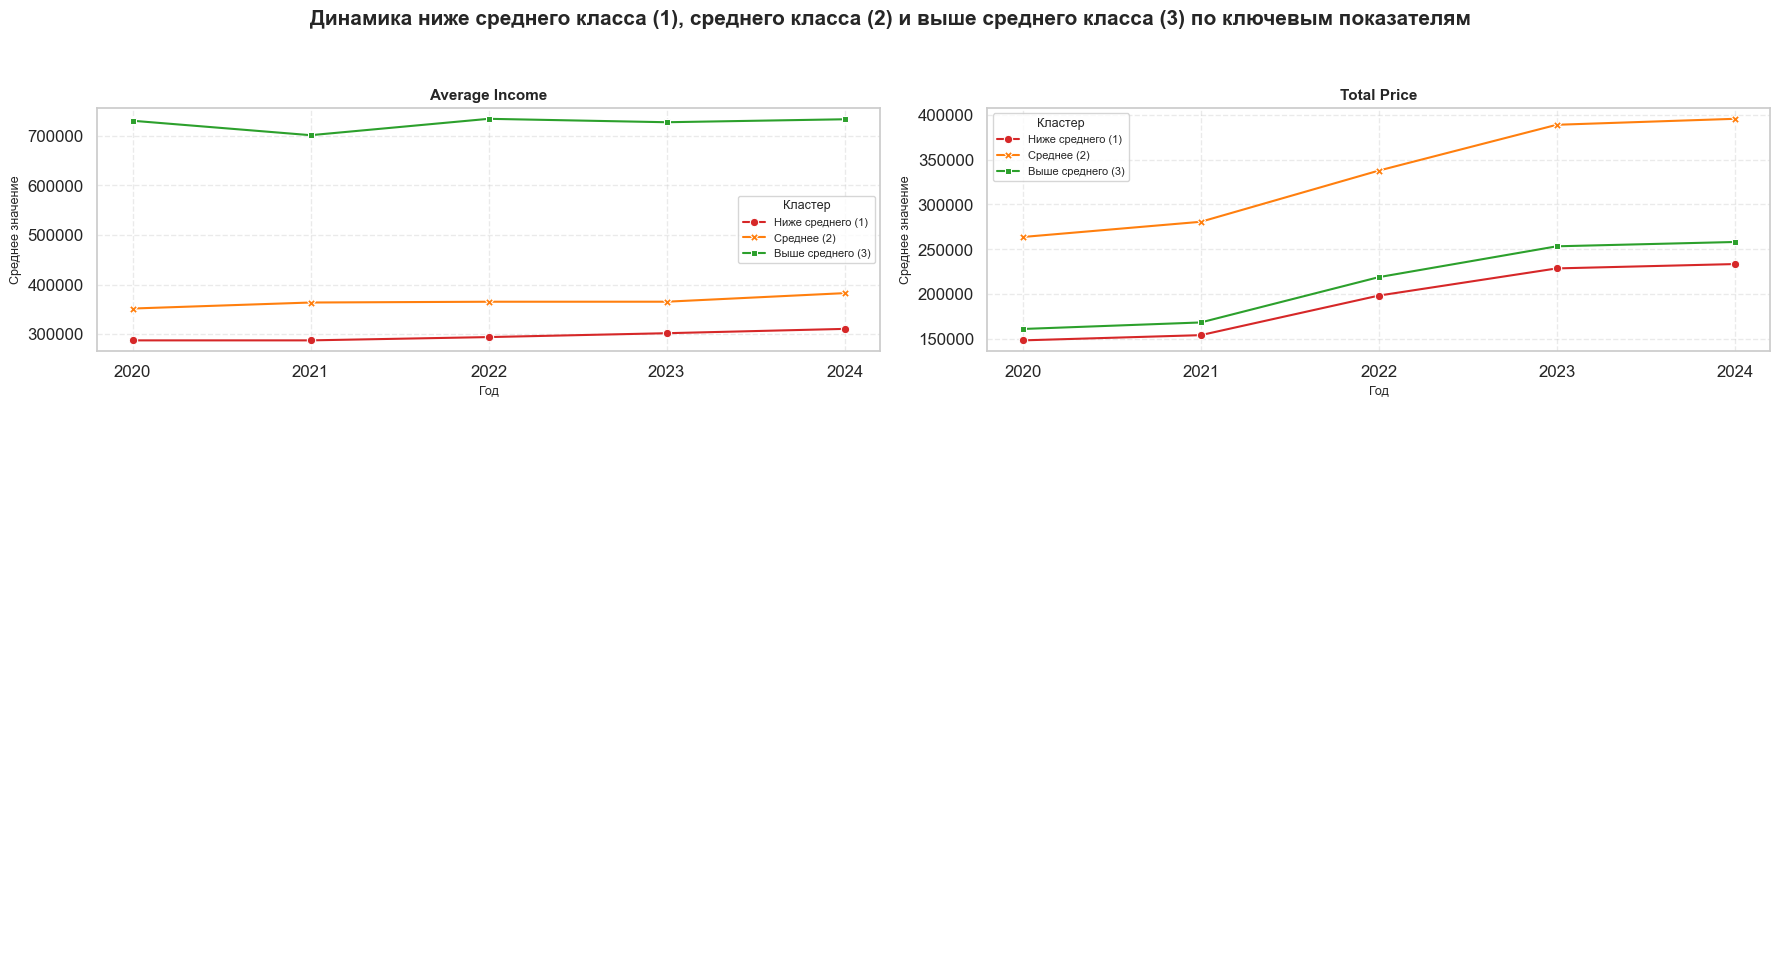

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define updated color palette to include third class (blue for third class)
palette = {1: "#d62728", 2: "#ff7f0e", 3: "#2ca02c"}  # red = poor, orange = medium, green = rich
cluster_labels = ["Ниже среднего (1)", "Среднее (2)", "Выше среднего (3)"]

metrics = [
    'average_income', 'total_price'
]

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(
        data=agg_all,
        x="year",
        y=metric,
        hue="reassigned_cluster",
        style="reassigned_cluster",
        markers=True,
        dashes=False,
        palette=palette,
        ax=axes[i]
    )
    axes[i].set_title(metric.replace("_", " ").title(), fontsize=11, fontweight="bold")
    axes[i].set_xlabel("Год", fontsize=9)
    axes[i].set_ylabel("Среднее значение", fontsize=9)
    axes[i].set_xticks(sorted(agg_all["year"].unique()))
    axes[i].grid(True, linestyle="--", alpha=0.4)

    # Get handles and labels
    handles, labels = axes[i].get_legend_handles_labels()
    
    # Ensure the new_order corresponds only to existing labels in handles
    new_order = [1, 2, 3]  # 1=poor, 2=medium, 3=rich
    existing_handles = [handles[j] for j in range(len(labels)) if int(labels[j]) in new_order]
    existing_labels = [cluster_labels[new_order.index(int(labels[j]))] for j in range(len(labels)) if int(labels[j]) in new_order]

    axes[i].legend(
        existing_handles,
        existing_labels,
        title="Кластер",
        fontsize=8,
        title_fontsize=9,
        loc="best"
    )

# Hide empty subplots if there are fewer metrics than subplots
for j in range(len(metrics), len(axes)):
    axes[j].axis("off")

# Overall title for the plot
plt.suptitle("Динамика ниже среднего класса (1), среднего класса (2) и выше среднего класса (3) по ключевым показателям",
             fontsize=15, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

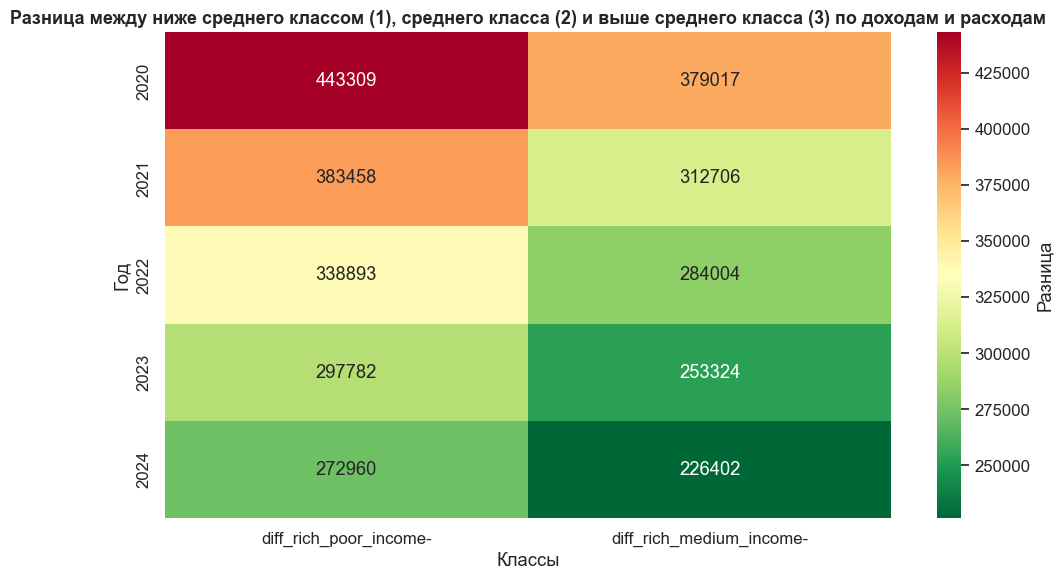

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame to get average_income and total_price for each year and wealth_label
pivot_df = agg_all.pivot(index="year", columns="reassigned_cluster", values=["average_income_real", "total_price_real"])

# Ensure all wealth labels (0, 1, 2) are present in the pivoted DataFrame
# Check for any missing wealth labels
required_labels = [1, 2, 3]
missing_labels = [label for label in required_labels if label not in pivot_df.columns.get_level_values(1)]

if missing_labels:
    print(f"Missing wealth labels: {missing_labels}")
else:
    # Calculate the differences: 
    diff_df = pivot_df.assign(
        diff_rich_poor_income=lambda x: x[("average_income_real", 3)] - x[("average_income_real", 1)],  # rich - poor for income
        diff_rich_medium_income=lambda x: x[("average_income_real", 3)] - x[("average_income_real", 2)],  # rich - medium for income
    )

    # Create the heatmap for the differences
    diff_df_plot = diff_df[["diff_rich_poor_income", "diff_rich_medium_income"]]

    # Plotting the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(diff_df_plot, annot=True, fmt=".0f", cmap="RdYlGn_r", cbar_kws={'label': 'Разница'})
    plt.title("Разница между ниже среднего классом (1), среднего класса (2) и выше среднего класса (3) по доходам и расходам", fontsize=13, fontweight="bold")
    plt.ylabel("Год")
    plt.xlabel("Классы")
    plt.tight_layout()
    plt.show()

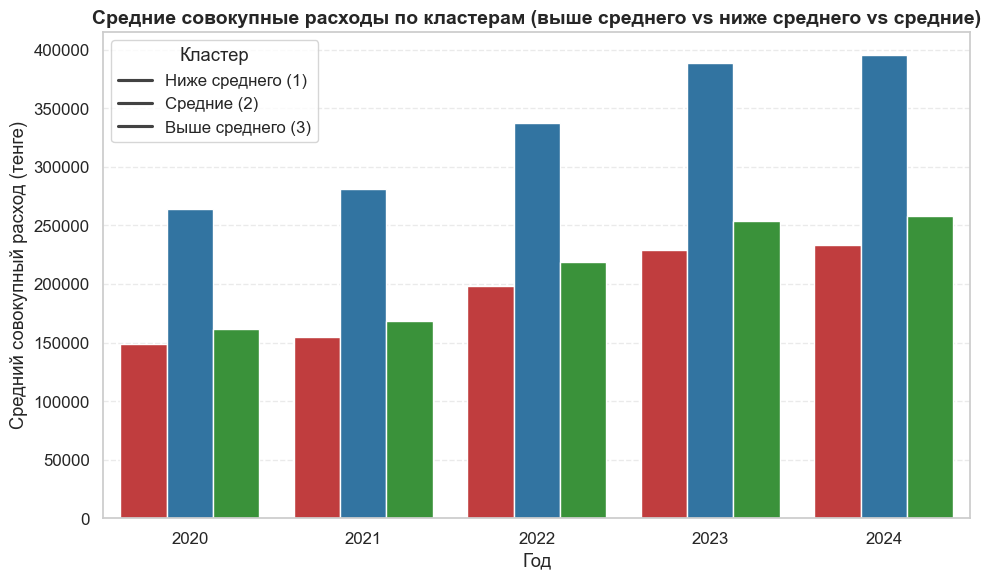

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette to include all three wealth labels
palette = {1: "#d62728", 2: "#1f77b4", 3: "#2ca02c"}  # red = poor, green = rich, blue = medium

# Plotting the bar plot with the updated palette
plt.figure(figsize=(10, 6))
sns.barplot(
    data=agg_all,
    x="year",
    y="total_price",
    hue="reassigned_cluster",
    palette=palette
)

# Title and labels
plt.title("Средние совокупные расходы по кластерам (выше среднего vs ниже среднего vs средние)", fontsize=14, fontweight="bold")
plt.xlabel("Год")
plt.ylabel("Средний совокупный расход (тенге)")

# Adjust legend to show three classes
plt.legend(title="Кластер", labels=["Ниже среднего (1)", "Средние (2)", "Выше среднего (3)"])

# Grid and layout adjustments
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

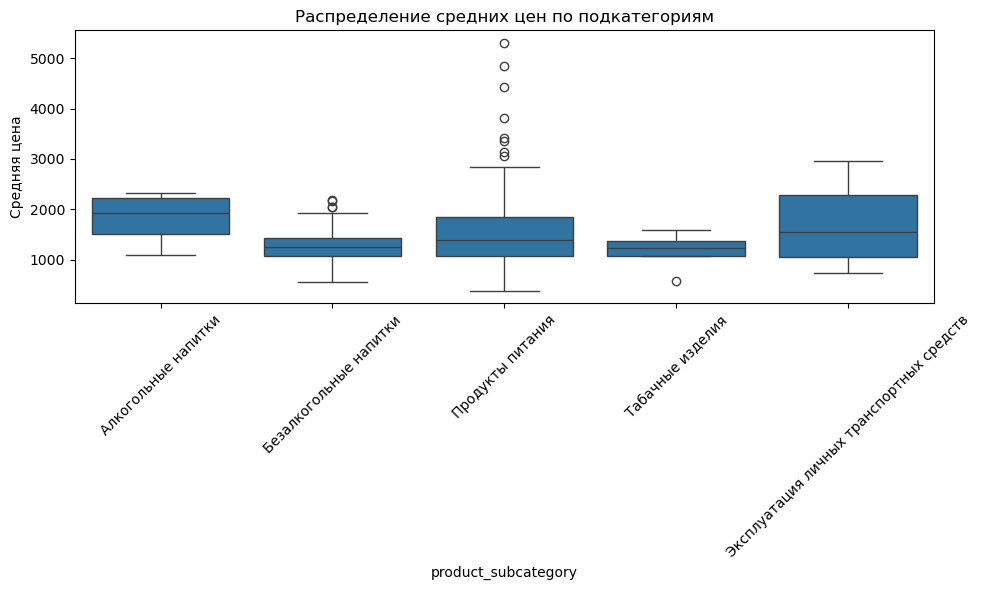

In [151]:
plt.figure(figsize=(10,6))
sns.boxplot(data=products_grouped_df, x="product_subcategory", y="mean")
plt.title("Распределение средних цен по подкатегориям")
plt.ylabel("Средняя цена")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

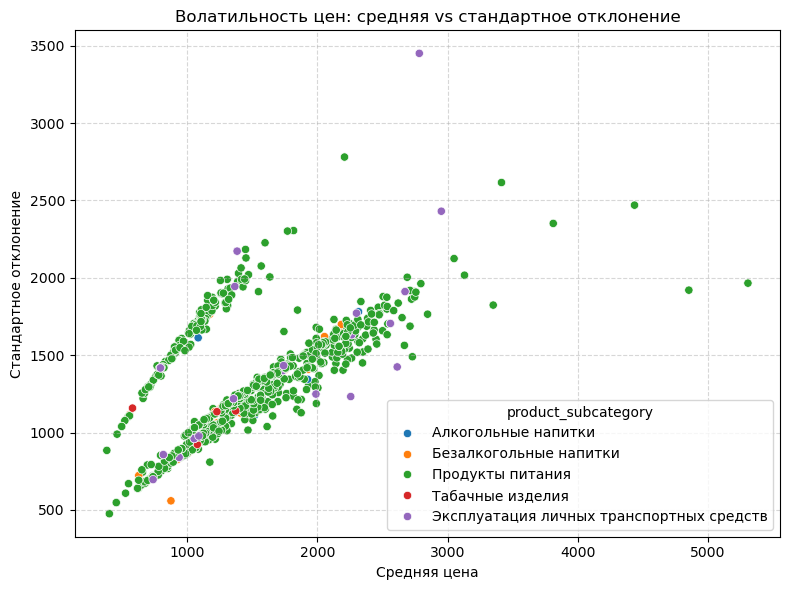

In [153]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=products_grouped_df, x="mean", y="std", hue="product_subcategory")
plt.title("Волатильность цен: средняя vs стандартное отклонение")
plt.xlabel("Средняя цена")
plt.ylabel("Стандартное отклонение")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

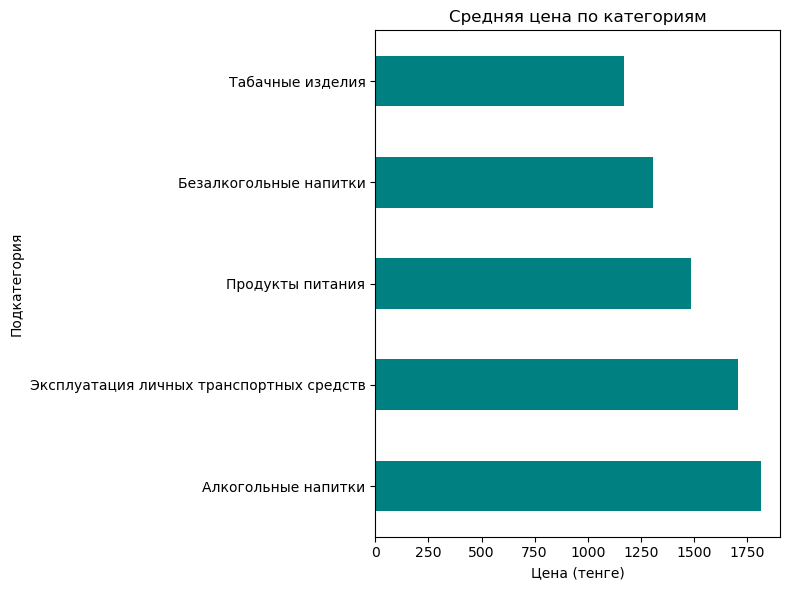

In [155]:
avg_cat = products_grouped_df.groupby("product_subcategory")["mean"].mean().sort_values(ascending=False)
avg_cat.plot(kind="barh", figsize=(8,6), color="teal")
plt.title("Средняя цена по категориям")
plt.xlabel("Цена (тенге)")
plt.ylabel("Подкатегория")
plt.tight_layout()
plt.show()

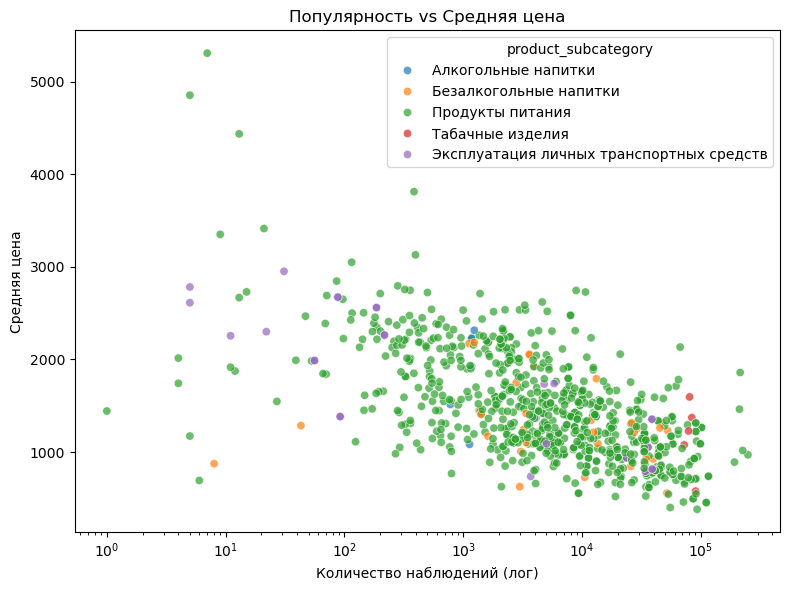

In [157]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=products_grouped_df, x="count", y="mean", hue="product_subcategory", alpha=0.7)
plt.xscale("log")
plt.title("Популярность vs Средняя цена")
plt.xlabel("Количество наблюдений (лог)")
plt.ylabel("Средняя цена")
plt.tight_layout()
plt.show()

In [189]:
region_grouped_df = (
    d003_merged.groupby(["year", "territory_code"])["price"]
      .agg(["count", "mean", "median", "max", 'std'])
      .reset_index()
)

top_territories = (
    region_grouped_df.groupby("territory_code")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .index
)

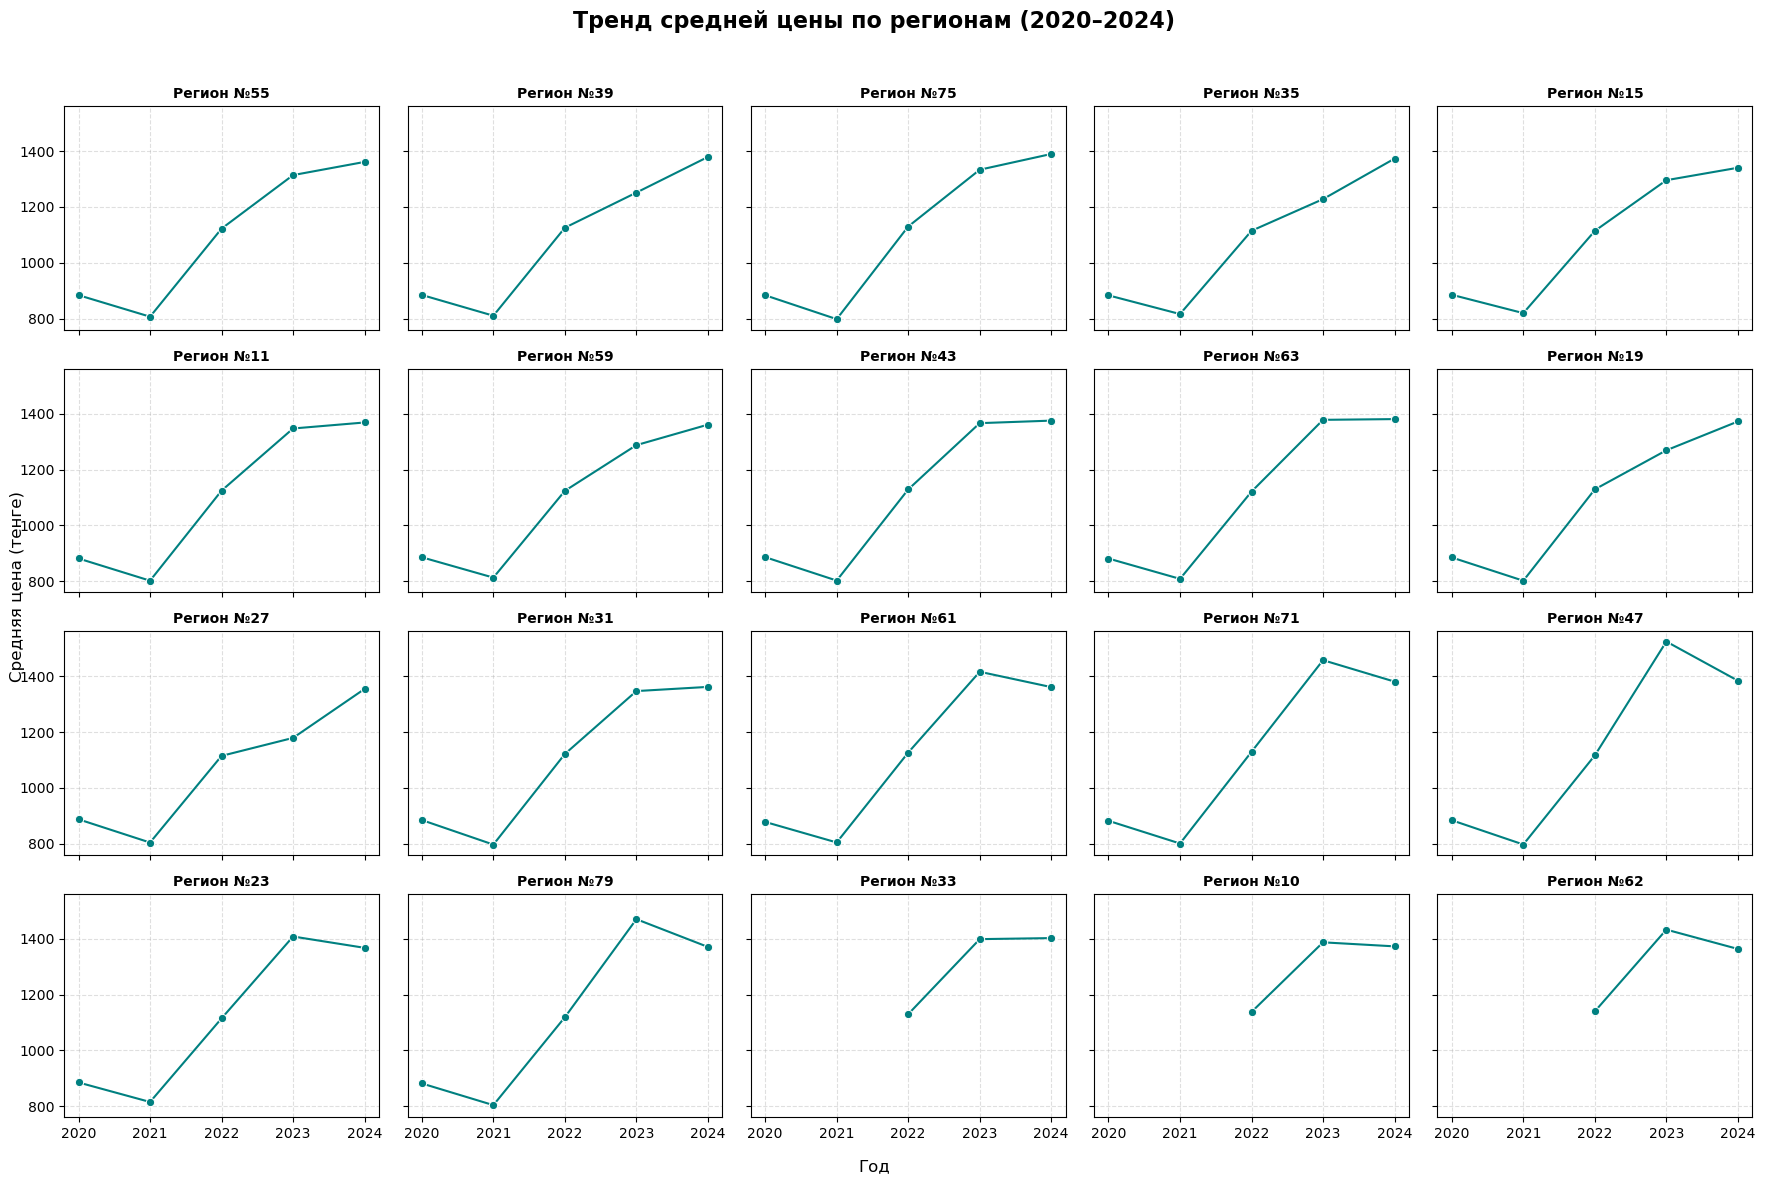

In [197]:
fig, axes = plt.subplots(4, 5, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, terr in enumerate(top_territories):
    ax = axes[i]
    subset = region_grouped_df[region_grouped_df["territory_code"] == terr]

    sns.lineplot(
        data=subset,
        x="year",
        y="mean",
        marker="o",
        color="teal",
        ax=ax
    )

    ax.set_title(f"Регион №{terr}", fontsize=10, fontweight="bold")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_xlabel("")
    ax.set_ylabel("")

# remove empty plots if < 20
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Тренд средней цены по регионам (2020–2024)", fontsize=16, fontweight="bold")
fig.supxlabel("Год")
fig.supylabel("Средняя цена (тенге)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [201]:
year_grouped_df = (
    d003_merged.groupby(["year", "product_subcategory"])["price"]
      .agg(["count", "mean", "median", "max", 'std'])
      .reset_index()
)

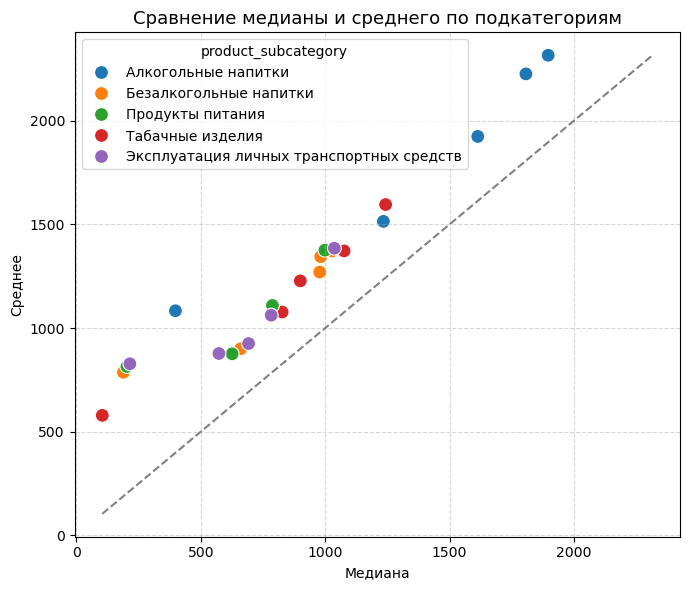

In [209]:
plt.figure(figsize=(7,6))
sns.scatterplot(data=year_grouped_df, x="median", y="mean", hue="product_subcategory", s=100)
plt.plot([year_grouped_df["median"].min(), year_grouped_df["mean"].max()],
         [year_grouped_df["median"].min(), year_grouped_df["mean"].max()],
         linestyle="--", color="gray")
plt.title("Сравнение медианы и среднего по подкатегориям", fontsize=13)
plt.xlabel("Медиана")
plt.ylabel("Среднее")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

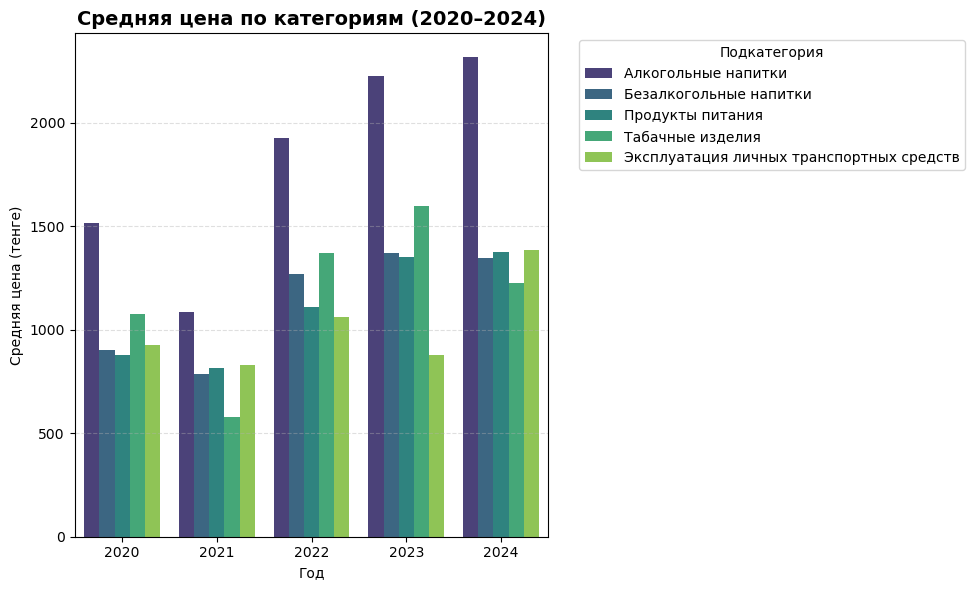

In [219]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=year_grouped_df,
    x="year",
    y="mean",
    hue="product_subcategory",
    palette="viridis"   # optional color scheme
)

plt.title("Средняя цена по категориям (2020–2024)", fontsize=14, fontweight="bold")
plt.ylabel("Средняя цена (тенге)")
plt.xlabel("Год")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="Подкатегория", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

In [117]:
temp = d003_merged.groupby(["year", "product_subcategory"])["price"].sum().reset_index()
temp["share"] = temp.groupby("year")["price"].transform(lambda x: round(x / x.sum() * 100, 2))
share_df = temp[["year", "product_subcategory", "share"]]

<Figure size 1000x600 with 0 Axes>

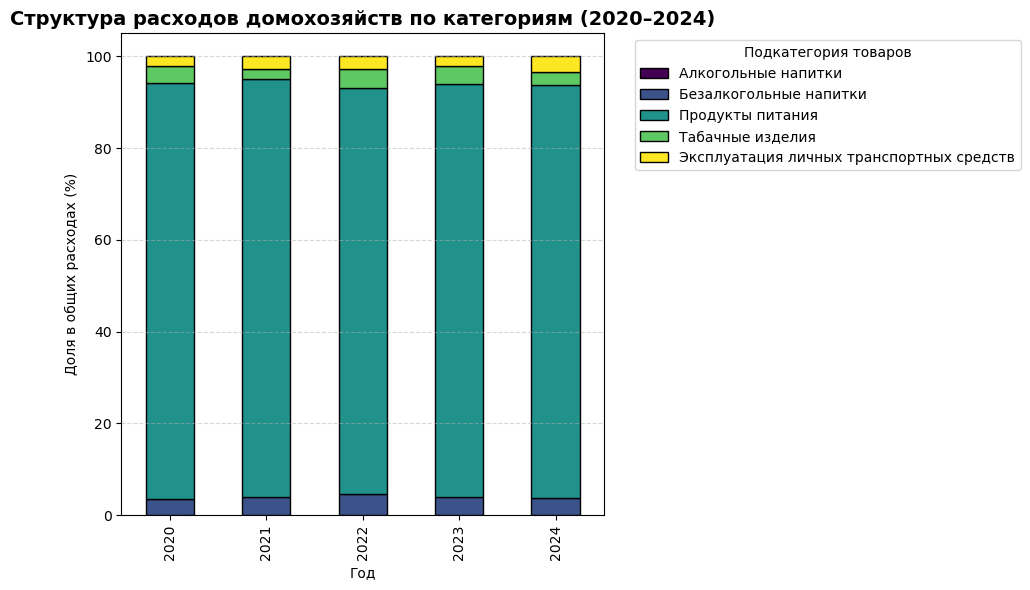

In [131]:
plt.figure(figsize=(10,6))
pivot_df.plot(
    kind="bar",
    stacked=True,
    colormap="viridis",
    figsize=(10,6),
    edgecolor='black'
)

plt.title("Структура расходов домохозяйств по категориям (2020–2024)", fontsize=14, fontweight="bold")
plt.ylabel("Доля в общих расходах (%)")
plt.xlabel("Год")
plt.legend(title="Подкатегория товаров", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()